In [2]:
%%capture --no-display
! pip install scipy
! pip install matplotlib 
! pip install seaborn

In [3]:
import json
import numpy as np
import pandas as pd
from src.pyipums.parse_xml import read_ipums_ddi
from ipumspy import readers, ddi
from matplotlib import pyplot as plt

In [4]:
ddi_file_path = "./cps_00003.xml"
data_file_path = "./cps_00003.dat.gz"

In [5]:
cps_ddi = read_ipums_ddi(ddi_file_path)
ddi_codebook = readers.read_ipums_ddi(ddi_file_path)

/Users/franciscojavierarceo/.pyenv/versions/3.8.16/lib/python3.8/site-packages/ipumspy/readers.py:47: CitationWarning: Use of data from IPUMS is subject to conditions including that users should cite the data appropriately.
See the `ipums_conditions` attribute of this codebook for terms of use.
See the `ipums_citation` attribute of this codebook for the appropriate citation.
  warnings.warn(


In [6]:
print(ddi_codebook.ipums_citation)

Publications and research reports based on the IPUMS-CPS database must cite it appropriately. The citation should include the following:

Sarah Flood, Miriam King, Renae Rodgers, Steven Ruggles, J. Robert Warren and Michael Westberry. Integrated Public Use Microdata Series, Current Population Survey: Version 10.0 [dataset]. Minneapolis, MN: IPUMS, 2022. https://doi.org/10.18128/D030.V10.0

The licensing agreement for use of IPUMS-CPS data requires that users supply us with the title and full citation for any publications, research reports, or educational materials making use of the data or documentation. Please add your citation to the IPUMS bibliography: http://bibliography.ipums.org/


In [9]:
xvars = [
    'AGE', 
    'ADJGINC', 
    'ASECWT', 
    'ASECWTH', 
    'ASIAN', 
    'ASECFWT', 
    'STATEFIP', 
    'TAXINC', 
    'UHRSWORK1', 
    'RACE', 
    'SEX', 
    'SRCWELFR', 
    'YEAR',
    'FOODSTAMP', 
    'STAMPVAL', 
    'WTFINL', 
    'BPL', 
    'HISPAN', 
    'EMPSTAT', 
    'LABFORCE', 
    'OCC', 
    'OCC2010',
    'MARST',
    'VETSTAT',
    'CITIZEN',
    'NATIVITY',
    'CLASSWKR',
    'WKSTAT',
    'EDUC',
    'OFFPOV',
    'EARNWT',
    'INCWAGE',
    'INCBUS',
    'INCFARM',
    'INCSS',
    'INCWELFR',
    'INCRETIR',
    'INCSSI',
    'INCINT',
    'INCUNEMP',
    'INCWKCOM',
    'INCVET',
    'INCSURV',
    'INCDISAB',
    'INCDIVID',
    'INCRENT',
    'INCEDUC',
    'INCCHILD',
    'INCASIST',
    'INCOTHER',
    'INCRANN',
    'INCPENS',
    'INCTOT',
]
ipums_df = readers.read_microdata(
    ddi_codebook,
    data_file_path,
    nrows=1e7,
    subset=xvars,
)
print(ipums_df)

         YEAR  ASECWTH  STATEFIP  STAMPVAL     WTFINL  ASECWT  AGE  SEX  RACE  \
0        2022      NaN         1      <NA>  1662.5757     NaN   36    2   100   
1        2022      NaN         1      <NA>  1978.1985     NaN   41    1   100   
2        2022      NaN         1      <NA>  1801.0842     NaN    5    2   100   
3        2022      NaN         1      <NA>  1243.6042     NaN    7    2   100   
4        2022      NaN         1      <NA>  2037.9611     NaN   50    2   200   
...       ...      ...       ...       ...        ...     ...  ...  ...   ...   
1869174  2023      NaN        56      <NA>   339.3124     NaN   43    2   100   
1869175  2023      NaN        56      <NA>   382.6062     NaN   46    1   100   
1869176  2023      NaN        56      <NA>   370.9985     NaN   50    2   100   
1869177  2023      NaN        56      <NA>   341.6635     NaN   74    1   100   
1869178  2023      NaN        56      <NA>   324.7941     NaN   71    2   100   

         MARST  ...  INCCHI

In [10]:
df = ipums_df[ipums_df['ASECWT'].isnull()==False].reset_index(drop=True)

In [12]:
invalids = {
    'INCSS':    999999,
    'INCWELFR': 999999.0,
    'INCRETIR': np.nan ,
    'INCSSI':   999999.0,
    'INCINT':   9999999.0,
    'INCUNEMP': 999999.0,
    'INCWKCOM': 999999.0,
    'INCVET':   9999999.0,
    'INCSURV':  9999999.0,
    'INCDISAB': 9999999,
    'INCDIVID': 9999999.0,
    'INCRENT':  9999999.0,
    'INCEDUC':  999999.0,
    'INCCHILD': 999999.0,
    'INCASIST': 9999999.0,
    'INCOTHER': 9999999.0,
    'INCRANN':  999999.0,
    'INCPENS':  999999.0,
    'TAXINC': 9999999.0,
    'INCTOT': np.nan,
    'INCWAGE': np.nan,
    'INCBUS': np.nan,
    'INCFARM': np.nan,
    'ADJGINC': np.nan,
}
for col in df.columns:
    if 'INC' in col:
        f = (df[col] == 99999999) | (df[col] ==999999999) | (df[col] == invalids[col])
        df[f"{col}_2"] = np.where(f, np.nan, df[col]) 

# Wage Decomposition

In [208]:
tmp = df[
    [f"{k}_2" for k in invalids]
].div(np.where(df["INCTOT_2"]!=0, df["INCTOT_2"], np.nan), axis=0).multiply(df['ASECWT'], axis=0).div(df['ASECWT'], axis=0)
tmp.columns = [f"PRCNT_{k}" for k in tmp.columns]
wage_decomp = tmp.mean().drop({"PRCNT_ADJGINC_2", "PRCNT_TAXINC_2", "PRCNT_INCTOT_2"}).sort_values() * 100.
wage_decomp.index = [
    ddi_codebook.get_variable_info(
        x.replace("PRCNT_", "").replace("_2", "")
    ).label.title().replace("Income From Ssi", "Supplemental Security Income (SSI)").replace("'S", "'s")
    for x in wage_decomp.index
]

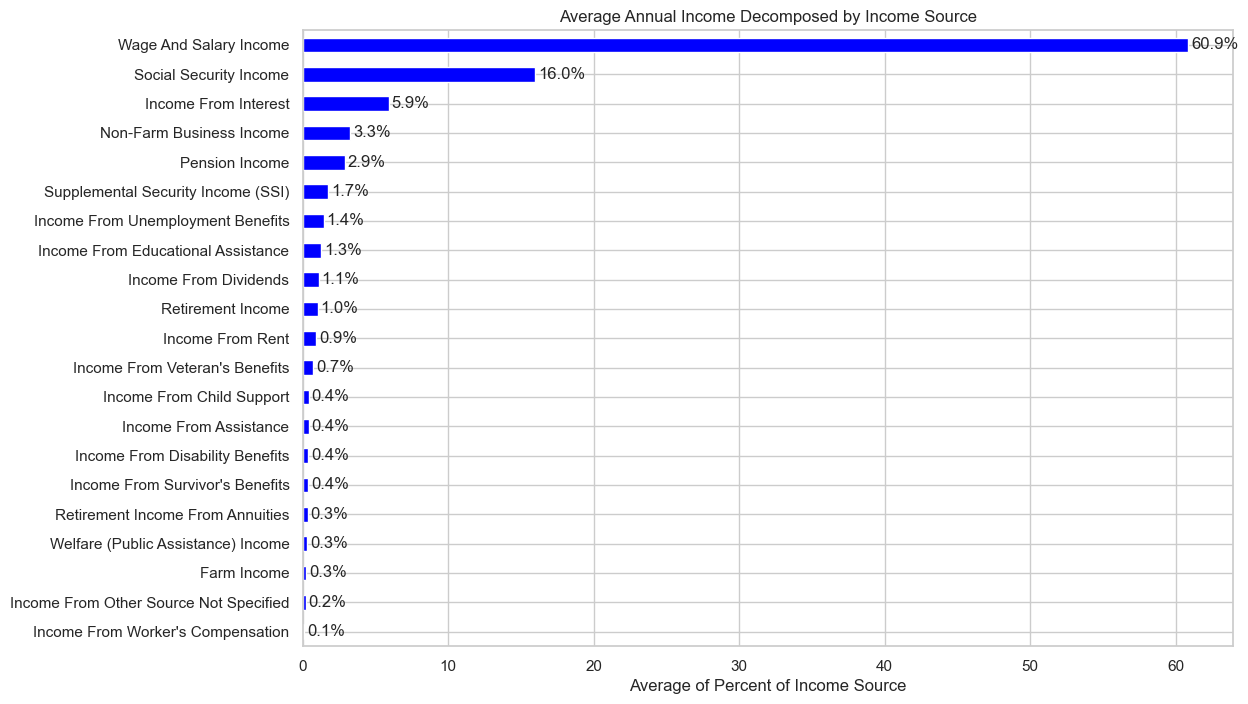

In [209]:
ax = wage_decomp.plot(kind='barh', color='blue', title="Average Annual Income Decomposed by Income Source")

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=2)

plt.xlabel("Average of Percent of Income Source")
plt.show()

In [212]:
wd_buckets = {
    "Income From Worker's Compensation": "Wages",
    'Income From Other Source Not Specified': "Unknown",
    'Farm Income': "Wages",
    'Welfare (Public Assistance) Income': "Government",
    'Retirement Income From Annuities': "Investments",
    "Income From Survivor's Benefits": "Government",
    'Income From Disability Benefits': "Government",
    'Income From Assistance': "Government",
    'Income From Child Support': "Government",
    "Income From Veteran's Benefits": "Government",
    'Income From Rent': "Investments",
    'Retirement Income': "Investments",
    'Income From Dividends': "Investments",
    'Income From Educational Assistance': "Government",
    'Income From Unemployment Benefits': "Government",
    'Supplemental Security Income (SSI)': "Government",
    'Pension Income': "Wages",
    'Non-Farm Business Income': "Wages",
    'Income From Interest': "Investments",
    'Social Security Income': "Government",
    'Wage And Salary Income': "Wages",
}

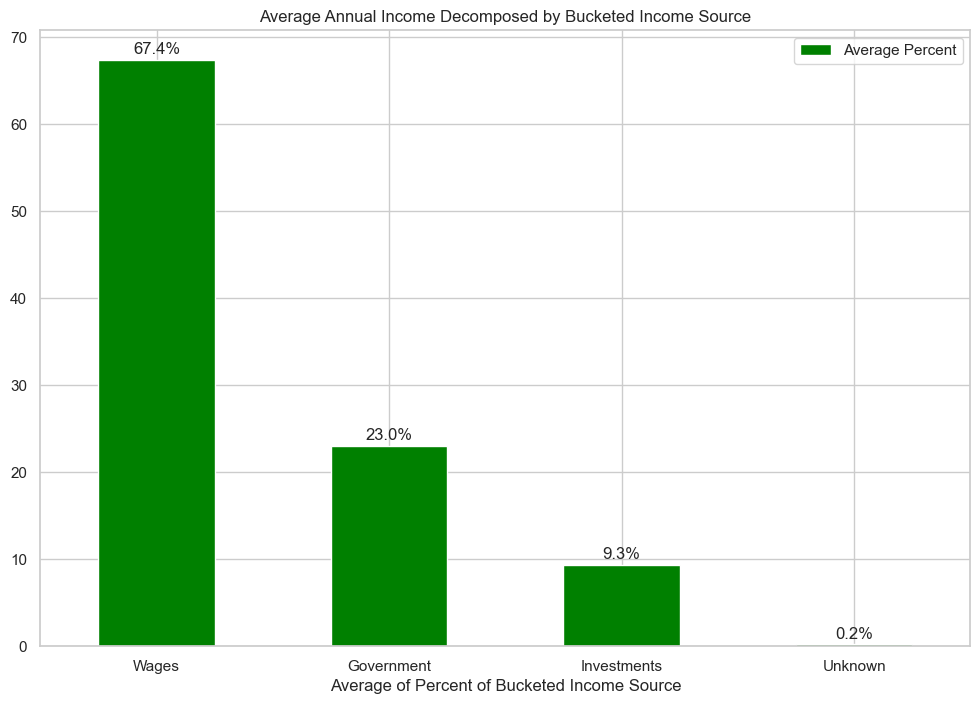

In [265]:
wdf = pd.DataFrame(wage_decomp, columns=['percent'])
wdf['Bucketed Income Source']= [wd_buckets[d] for d in wdf.index]
wdf2 = pd.DataFrame(wdf.groupby(by='Bucketed Income Source').sum()).sort_values(by='percent', ascending=False)
wdf2.rename({"percent": "Average Percent"}, axis=1, inplace=True)
ax = wdf2.plot(kind='bar', color='green', title="Average Annual Income Decomposed by Bucketed Income Source")

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=2)

plt.xlabel("Average of Percent of Bucketed Income Source")
plt.xticks(rotation='horizontal')
plt.show()

In [55]:
def map_codes(ddi, xdf, xvar):
    g = {v:k for k,v in ddi.get_variable_info(xvar).codes.items()}
    res = xdf[xvar].apply(lambda x: g.get(x, None))
    return res

EDUC_LT_HS = 'Less than High School Diploma'
EDUC_HS = 'High school diploma or equivalent'
EDUC_VOC = 'Vocational Degree'
EDUC_BS = "Bachelor's degree"
EDUC_GRAD = "Graduate degree"
educ_attain = {
    'NIU or blank': 'Missing',
    'Grades 1, 2, 3, or 4': EDUC_LT_HS,
    'Grades 5 or 6': EDUC_LT_HS,
    'Grades 7 or 8': EDUC_LT_HS,
    'Grade 9': EDUC_LT_HS,
    'Grade 10': EDUC_LT_HS,
    'Grade 11': EDUC_LT_HS,
    '12th grade, no diploma': EDUC_LT_HS,
    'None or preschool': EDUC_LT_HS,
    'High school diploma or equivalent': EDUC_HS,
    "Associate's degree, academic program": EDUC_HS,
    "Associate's degree, occupational/vocational program": EDUC_VOC,
    'Some college but no degree': EDUC_HS,
    "Bachelor's degree": EDUC_BS,
    "Master's degree": EDUC_GRAD,
    'Doctorate degree': EDUC_GRAD,
    'Professional school degree': EDUC_GRAD,
}

df['Occupation'] = map_codes(ddi_codebook, df, 'OCC2010')
df['Education'] = map_codes(ddi_codebook, df, 'EDUC')
df['Educational_Attainment'] = df['Education'].apply(lambda x: educ_attain.get(x)).astype(str)
df['Birthplace'] = map_codes(ddi_codebook, df, 'BPL')
df['Marital_Status'] = map_codes(ddi_codebook, df, 'MARST')
df['Nativity'] = map_codes(ddi_codebook, df, 'NATIVITY')
df['Class_of_worker'] = map_codes(ddi_codebook, df, 'CLASSWKR')
df['Hispanic'] = map_codes(ddi_codebook, df, 'HISPAN')
df['Asian'] = map_codes(ddi_codebook, df, 'ASIAN')
df['Race'] = map_codes(ddi_codebook, df, 'RACE')
df['Veteran_Status'] = map_codes(ddi_codebook, df, 'VETSTAT')
df['Age_bucket'] = "Age " + pd.qcut(df['AGE'], q=5).astype(str)
df['income_null'] = df['INCTOT_2'].isnull()

In [77]:
def pt(ddi: ddi.Codebook, df: pd.DataFrame, xvar: str, wvar: str=None):
    if ddi:
        codex = pd.DataFrame.from_dict(ddi.get_variable_info(xvar).codes, orient='index', columns=['code'])
        codex.reset_index(inplace=True)
        codex.rename({"index": xvar}, axis=1, inplace=True)
    if wvar:
        aggdf = df[[xvar, wvar]].groupby(by=xvar, as_index=False).agg({wvar: [np.sum, len]})
        aggdf.columns = ['_'.join([y for y in j if y != '']) for j in aggdf.columns]
        aggdf.rename({xvar: "code", f"{wvar}_sum": "count", f"{wvar}_len": "raw_count"}, inplace=True, axis=1)
        aggdf['raw_percent'] = aggdf['raw_count'] / aggdf['raw_count'].sum()
    else:
        aggdf = pd.DataFrame(
            df[xvar].value_counts().reset_index()
        ).rename({"index": 'code', xvar: 'count'}, axis=1)
        
    aggdf['Percent'] = aggdf['count'] / aggdf['count'].sum()
    if ddi:
        outdf = aggdf.merge(codex, how='left', left_on='code', right_on='code')    
    else:
        outdf = aggdf.rename({"code": xvar}, axis=1)
    outdf.sort_values(by='count', ascending=False, inplace=True)
    outdf.reset_index(drop=True, inplace=True)
    if ddi:
        outdf = outdf[[xvar] + outdf.columns[0:-1].to_list()]
    return outdf

def ptbarplot(ddi, df, xvar, wvar, color='blue', out=False):
    x = pt(ddi, df, xvar, wvar)
    try:
        ylabel = ddi.get_variable_info(xvar).label.title()
    except:
        ylabel = xvar
    x['Percent'] = (x['Percent'] * 100.).round(2)

    y = x[['Percent', xvar]].sort_values(by='Percent', ascending=False).reset_index(drop=True).loc[0:30]
    ax = y.sort_values(by='Percent').plot.barh(x=xvar, color=color, figsize=(12, 8))

    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f%%', padding=2)

    plt.legend(loc='lower right')
    plt.ylabel(ylabel)
    plt.xlabel("Percent of ASEC Sample")
    plt.show()    
    if out:
        return x

In [57]:
df['RACE_ORIGINAL'] = df['RACE']
x = pt(None, df, 'Race', 'ASECWT')
races = list(x.iloc[0:4,0].values)

df['Race_top_5'] = df['Race'].apply(lambda x: x if x in races else 'Other')

df['Race_full'] = np.where(df['Hispanic']!='Not Hispanic', 'Hispanic', df['Race_top_5'])

In [58]:
df['INCTOT_3'] = np.where(
    df['INCTOT_2'].fillna(0) < 0, 
    0, 
    df['INCTOT_2'].fillna(0)
)

df['Income Buckets'] = pd.qcut(df['INCTOT_3'], 10, duplicates='drop')

In [59]:
def clean_dollars(x):
    y = x.split(", ")
    left = round(float(y[0].replace("(", "")))
    right = round(float(y[1].replace("]", "")))
    output = f"(\${left:,}, \${right:,}]"
    return output

In [60]:
pt(ddi_codebook, df, 'LABFORCE')

LABFORCE  code  count   Percent
0     Yes, in the labor force     2  73863  0.483612
1  No, not in the labor force     1  46751  0.306098
2                         NIU     0  32118   0.21029

In [61]:
df2 = df[df.LABFORCE==2].reset_index(drop=True)

In [62]:
sdf = pd.crosstab(
    df2['Income Buckets'].astype(str).apply(lambda x: clean_dollars(x)), 
    df2['Race_full'], 
    df2['ASECWT'], 
    aggfunc = len
).rename_axis(None, axis=1)

In [63]:
print('Percent of Total')
(sdf.div(sdf.sum().sum()) * 100).round(1).style.background_gradient(axis=None, cmap='coolwarm').format('{:,.1f}%')

Percent of Total


In [64]:
print('Percent Down Columns')
(sdf.div(sdf.sum(axis=0)) * 100).round(1).style.background_gradient(axis=0, cmap='coolwarm').format('{:,.1f}%')

Percent Down Columns


In [65]:
print('Percent Across Rows')
(sdf.divide(sdf.sum(axis=1), axis=0) * 100).round(1).style.background_gradient(
    axis=1, cmap='coolwarm').format('{:,.1f}%')

Percent Across Rows


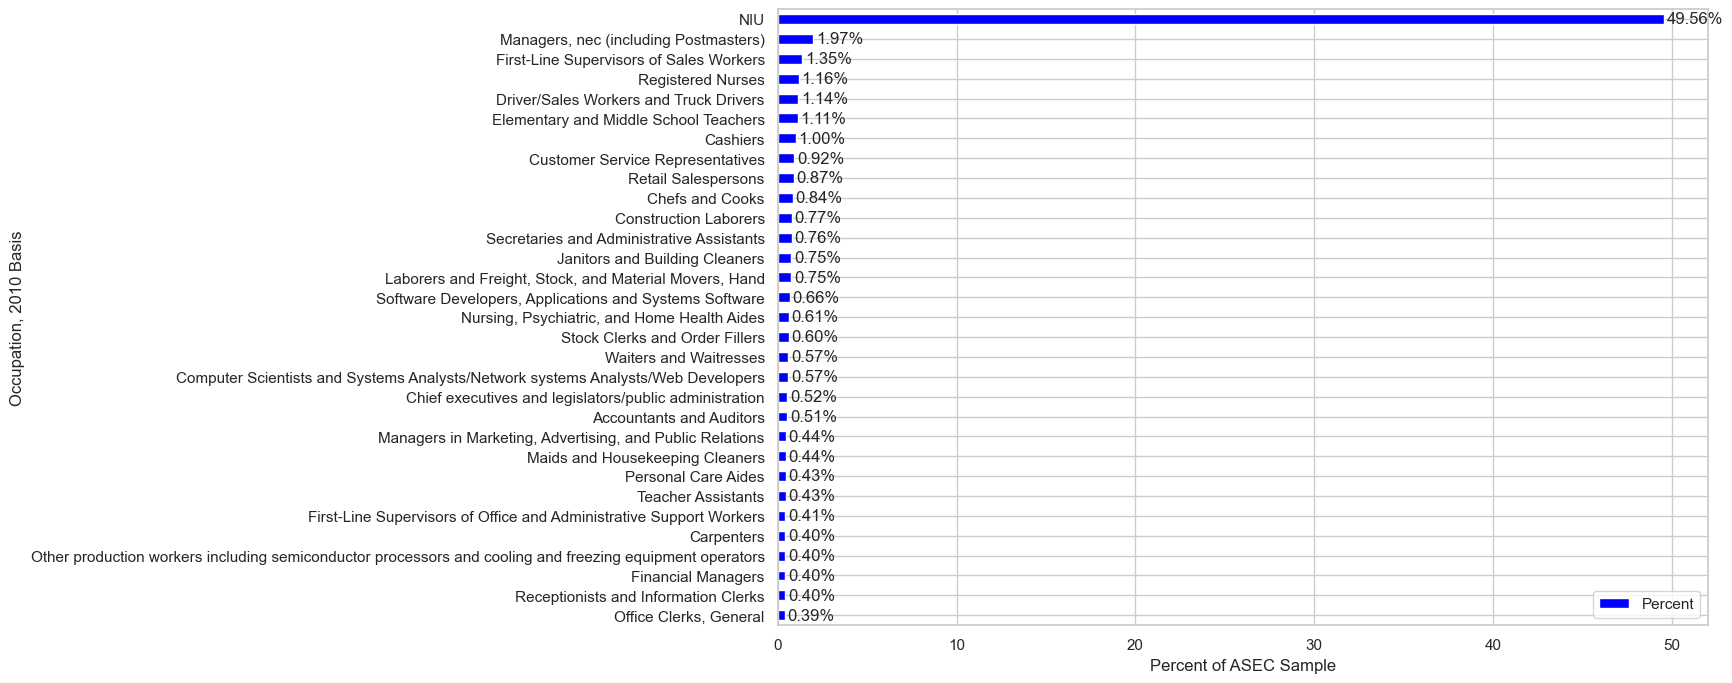

In [78]:
# ptbarplot(ddi_codebook, df[df['OCC2010']!=9999], 'OCC2010', 'ASECWT', color='blue')
ptbarplot(ddi_codebook, df, 'OCC2010', 'ASECWT', color='blue')

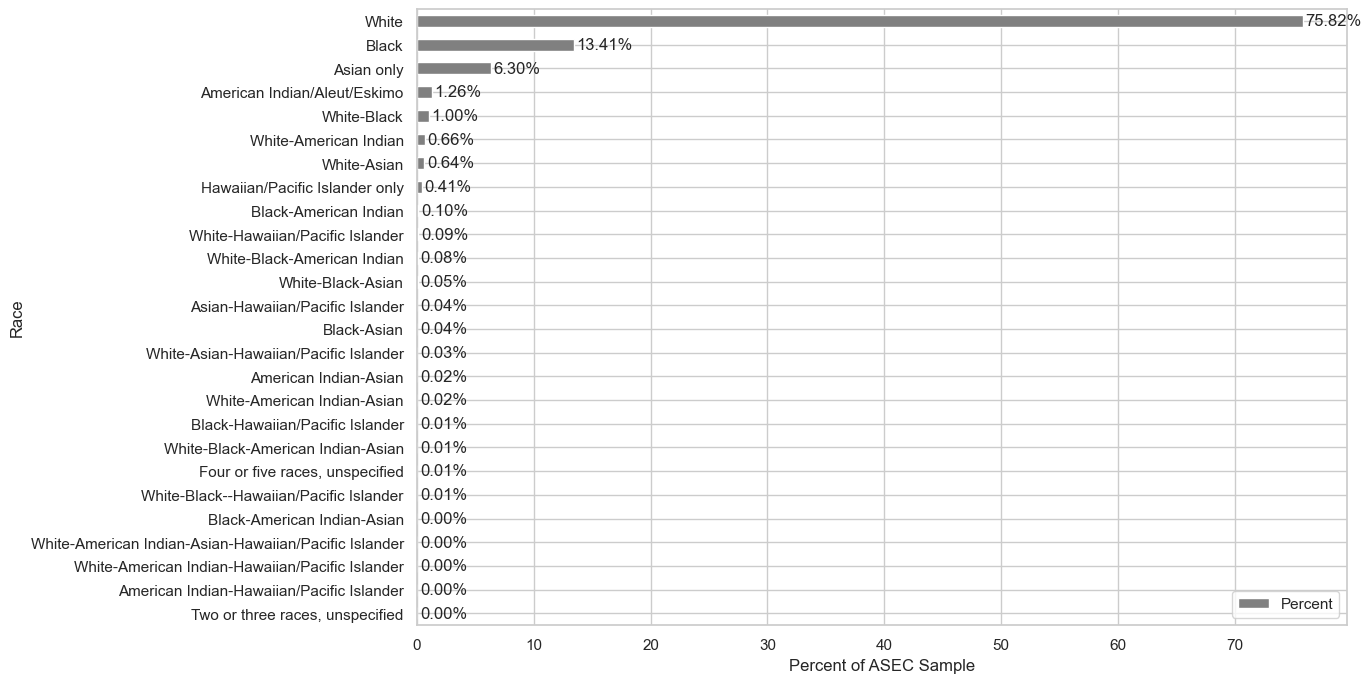

In [79]:
ptbarplot(ddi_codebook, df, 'RACE', 'ASECWT', color='gray')

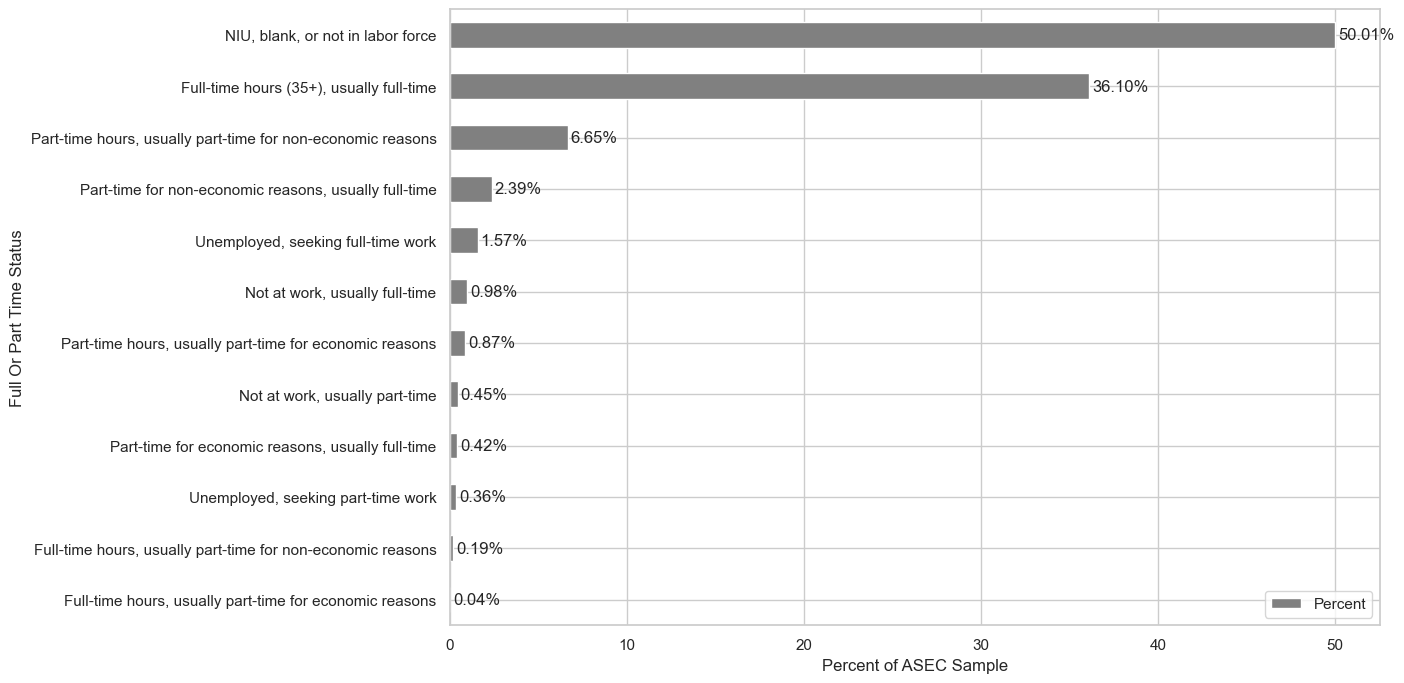

In [80]:
ptbarplot(ddi_codebook, df, 'WKSTAT', 'ASECWT', color='gray')

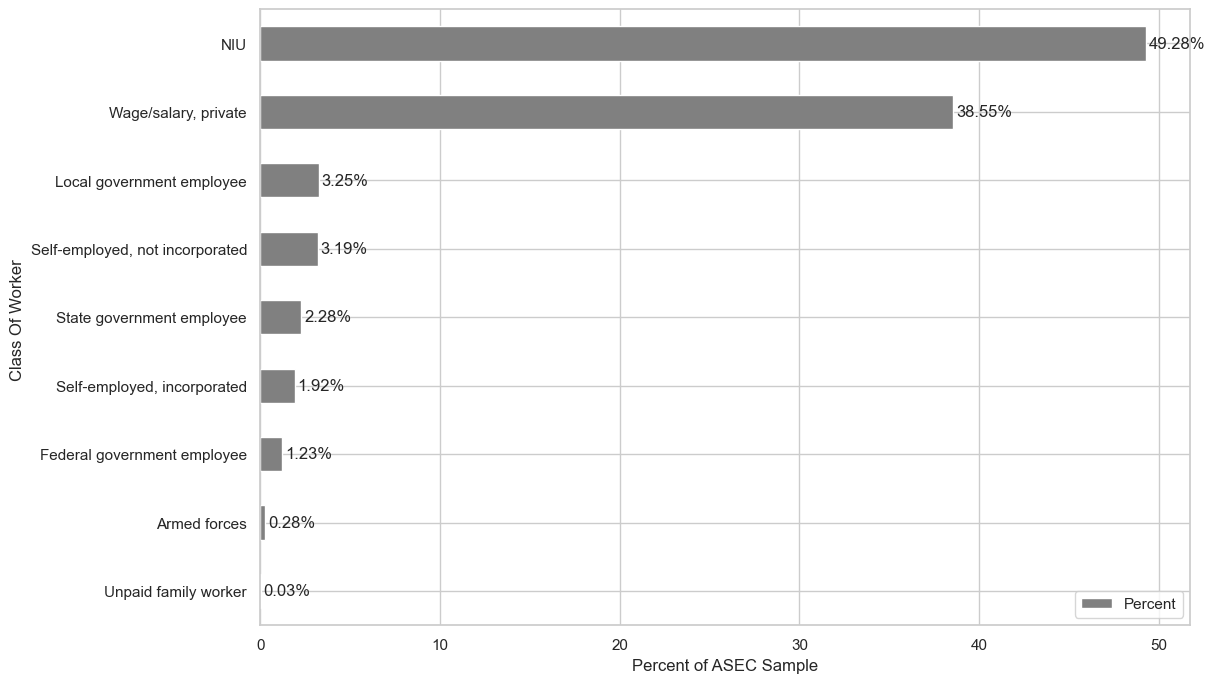

In [81]:
ptbarplot(ddi_codebook, df, 'CLASSWKR', 'ASECWT', color='gray')

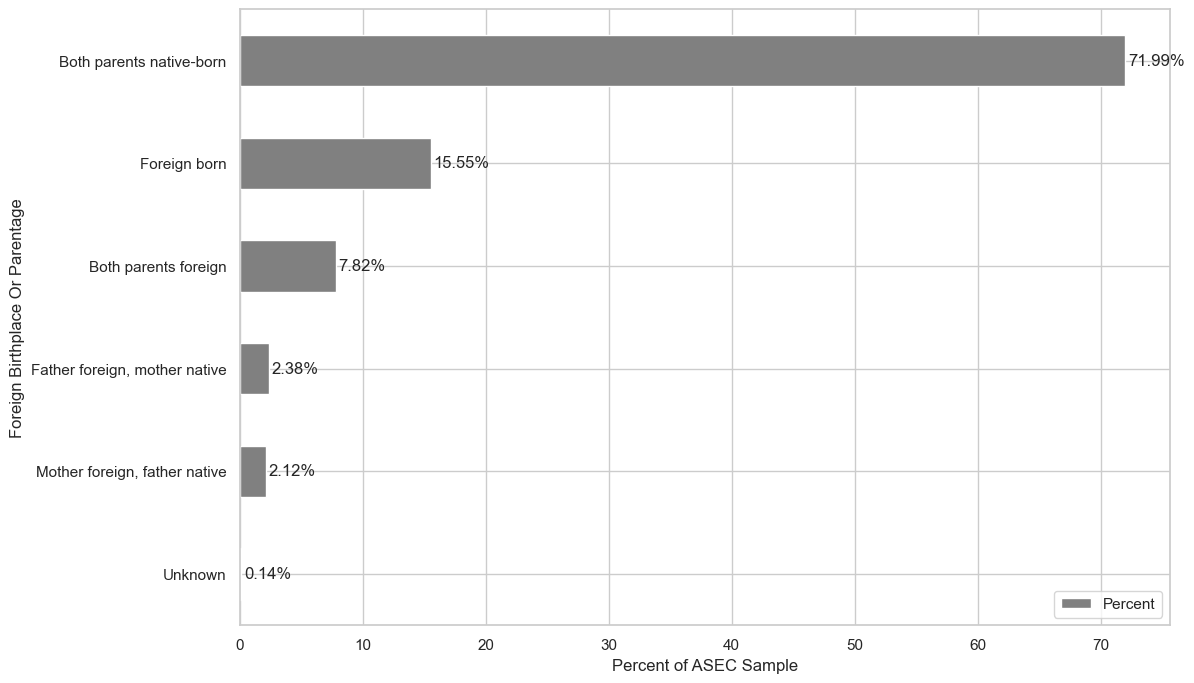

In [82]:
ptbarplot(ddi_codebook, df, 'NATIVITY', 'ASECWT', color='gray')

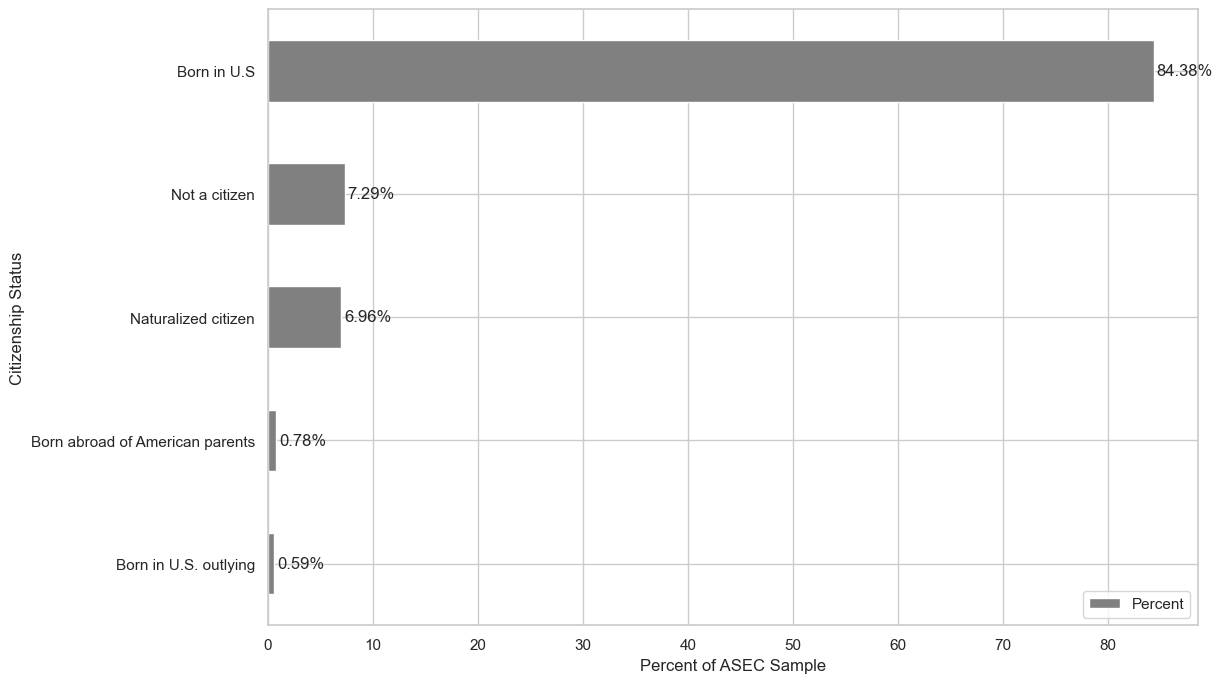

In [83]:
ptbarplot(ddi_codebook, df, 'CITIZEN', 'ASECWT', color='gray')

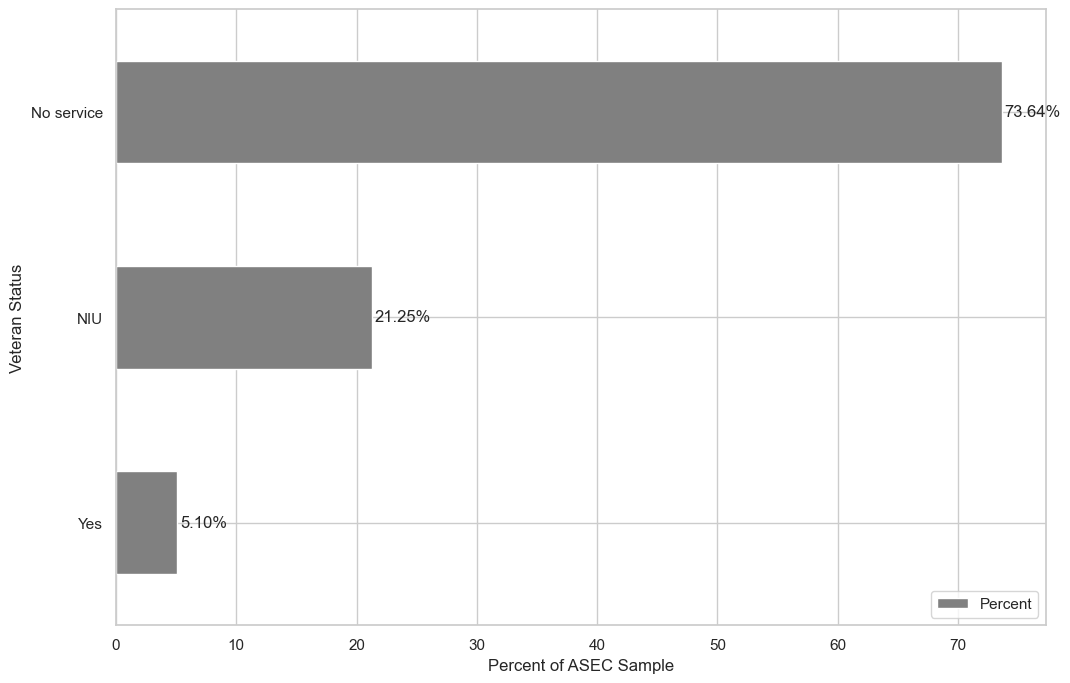

In [84]:
ptbarplot(ddi_codebook, df, 'VETSTAT', 'ASECWT', color='gray')

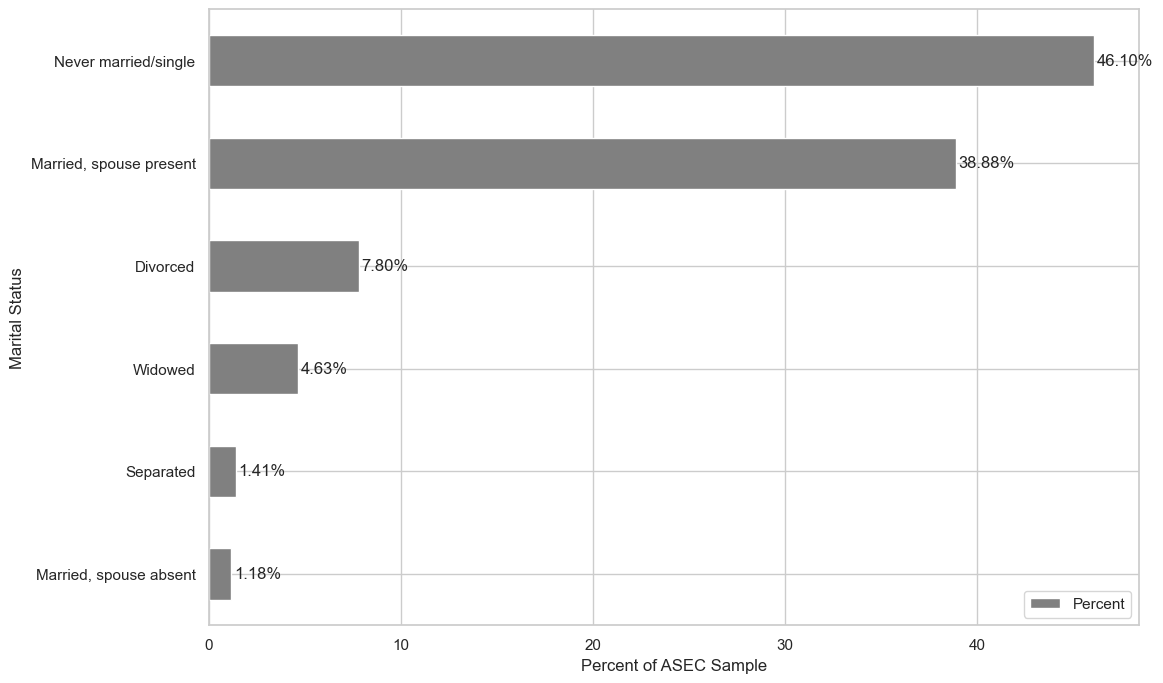

In [85]:
ptbarplot(ddi_codebook, df, 'MARST', 'ASECWT', color='gray')

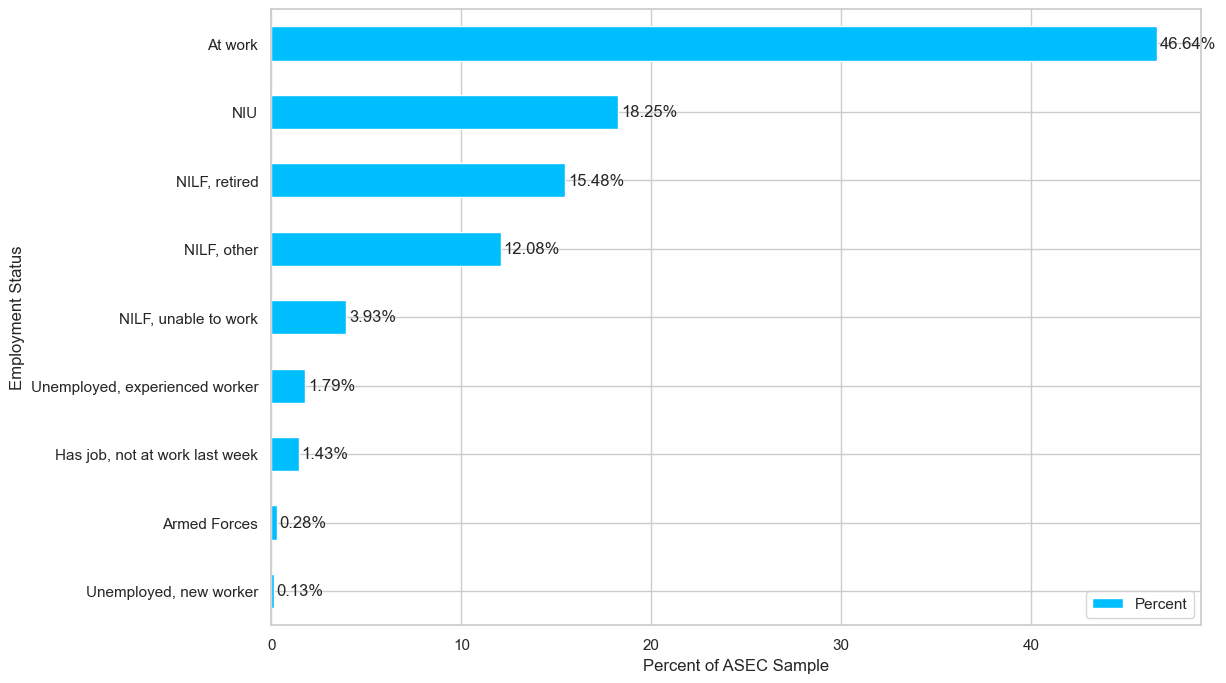

In [86]:
ptbarplot(ddi_codebook, df, 'EMPSTAT', 'ASECWT', color='deepskyblue')

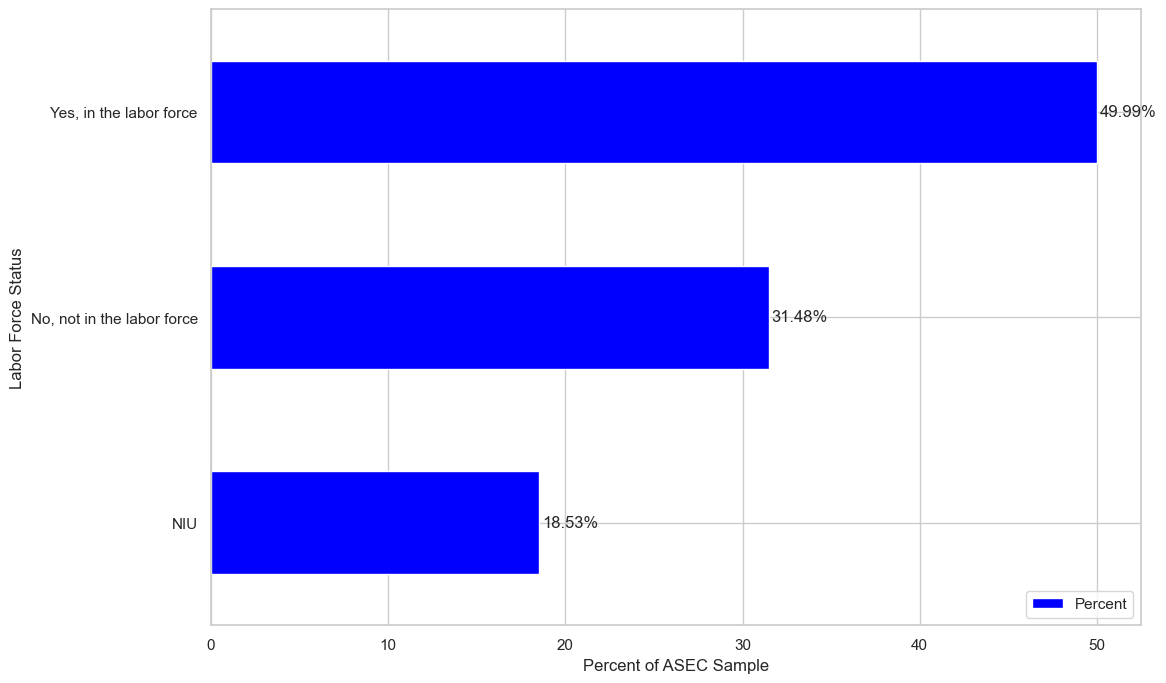

In [87]:
ptbarplot(ddi_codebook, df, 'LABFORCE', 'ASECWT', color='blue')

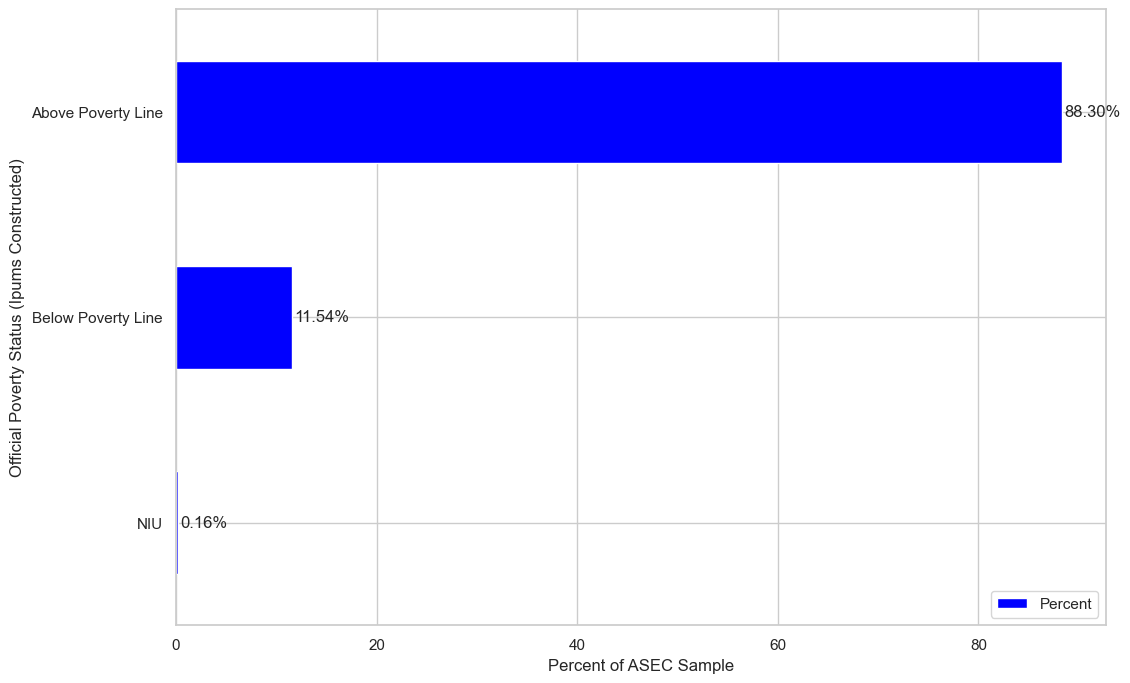

In [88]:
ptbarplot(ddi_codebook, df, 'OFFPOV', 'ASECWT', color='blue')

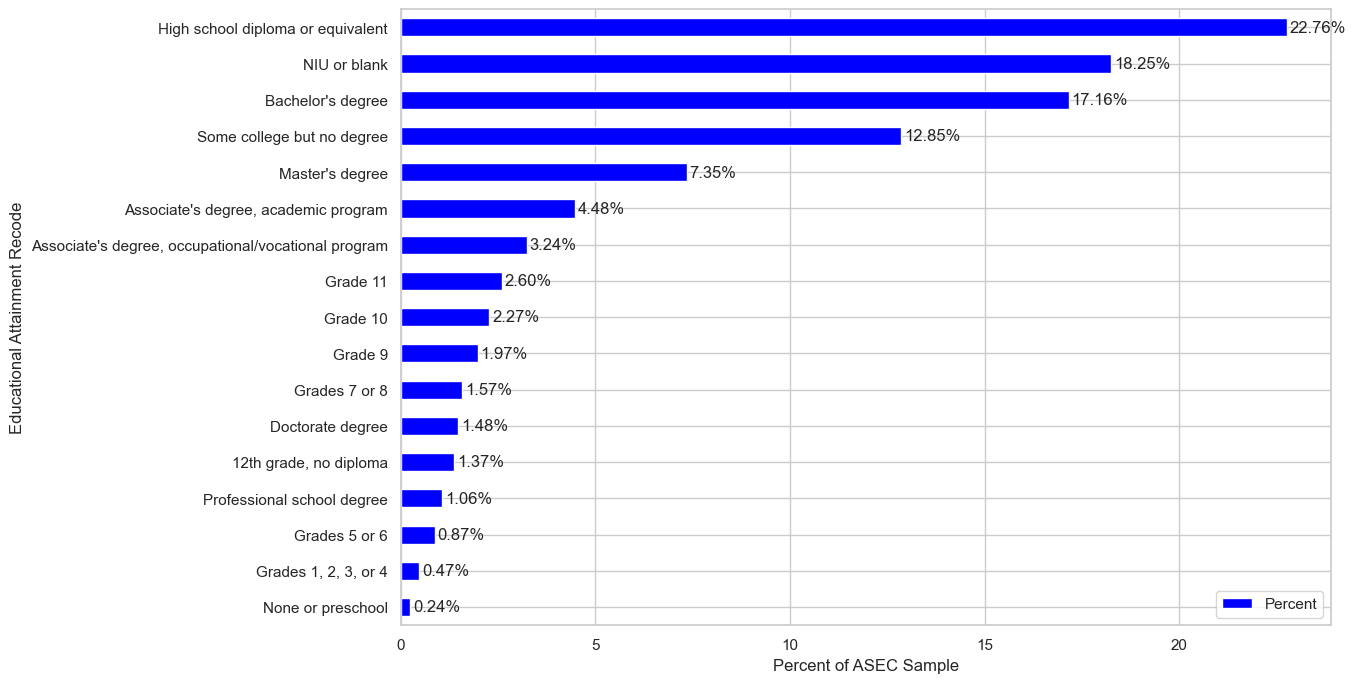

In [89]:
ptbarplot(ddi_codebook, df, 'EDUC', 'ASECWT',  color='blue')

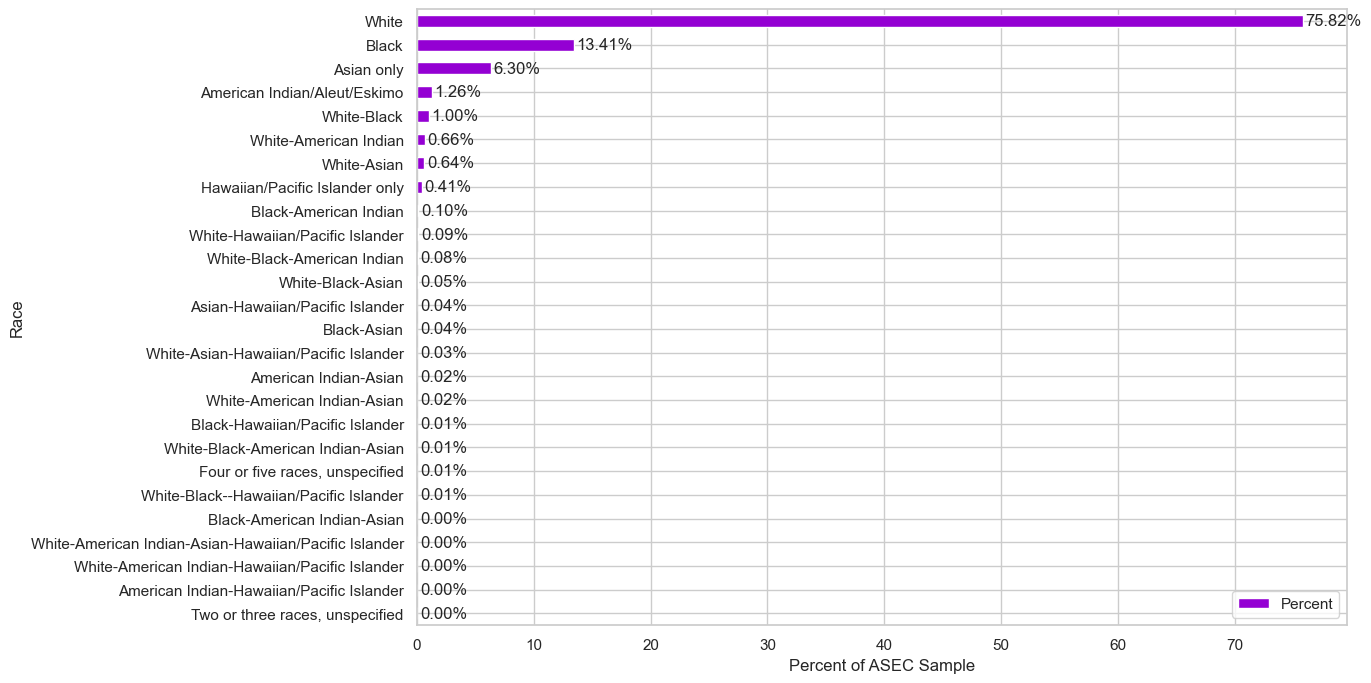

In [90]:
ptbarplot(ddi_codebook, df, 'RACE', 'ASECWT', color='darkviolet')

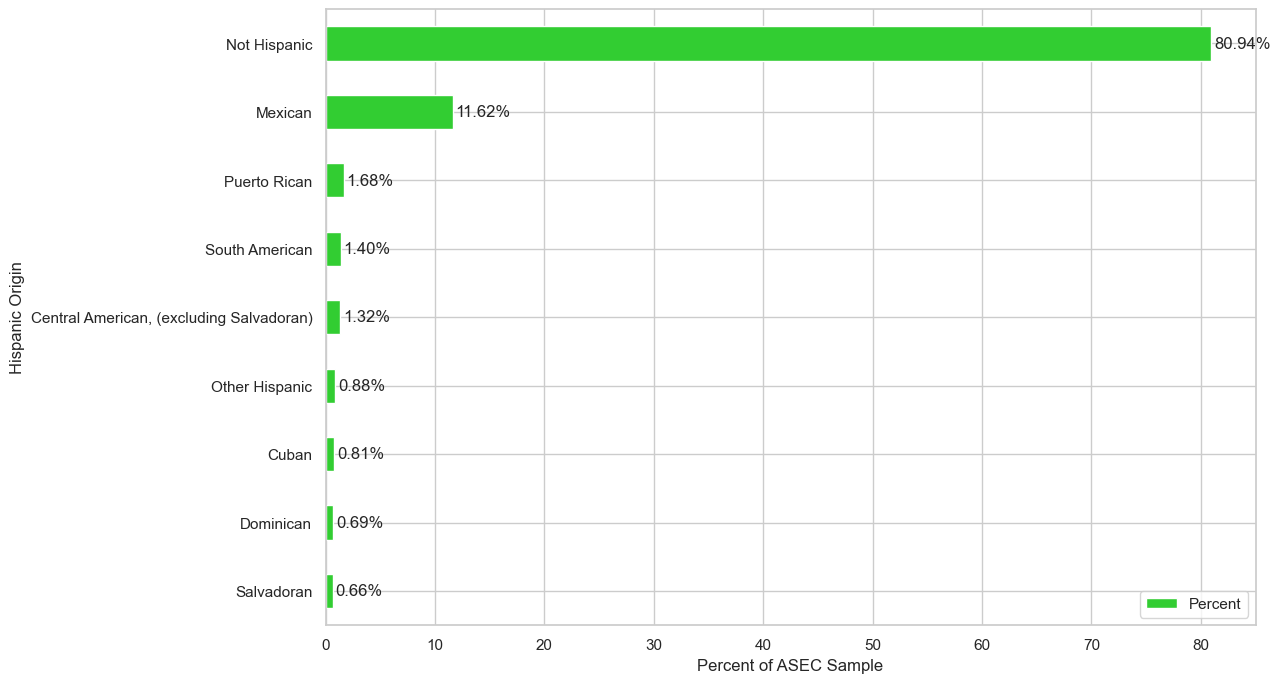

In [91]:
ptbarplot(ddi_codebook, df, 'HISPAN', 'ASECWT', color='limegreen')

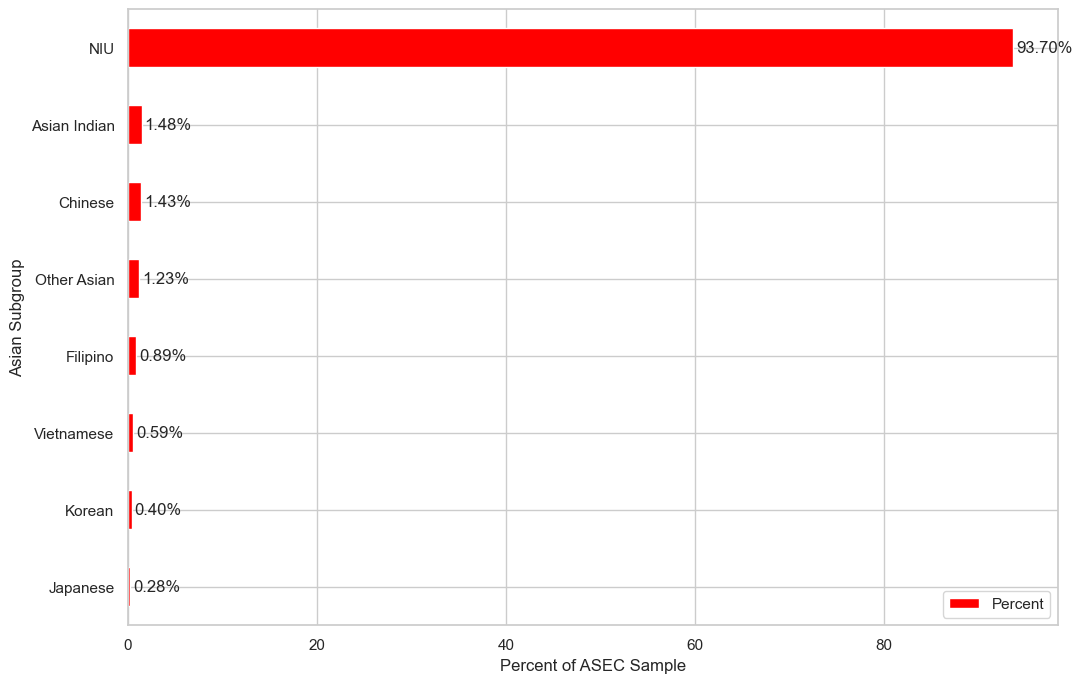

In [92]:
ptbarplot(ddi_codebook, df, 'ASIAN', 'ASECWT', color='red')

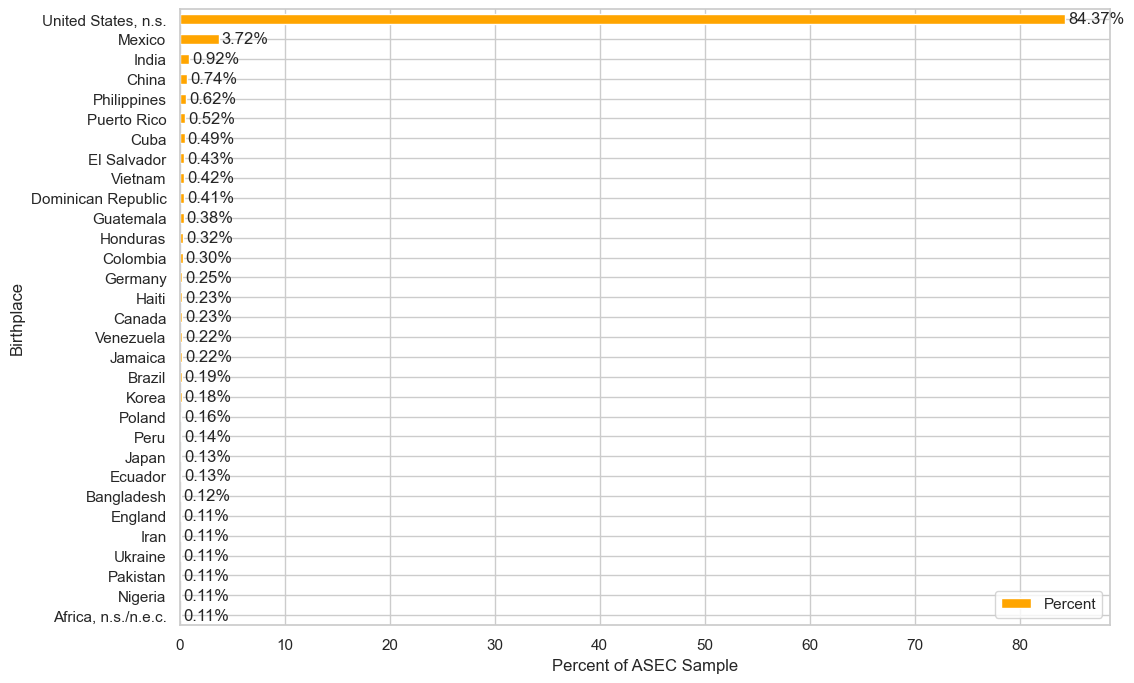

In [93]:
ptbarplot(ddi_codebook, df, 'BPL', 'ASECWT', color='orange')

<Axes: >

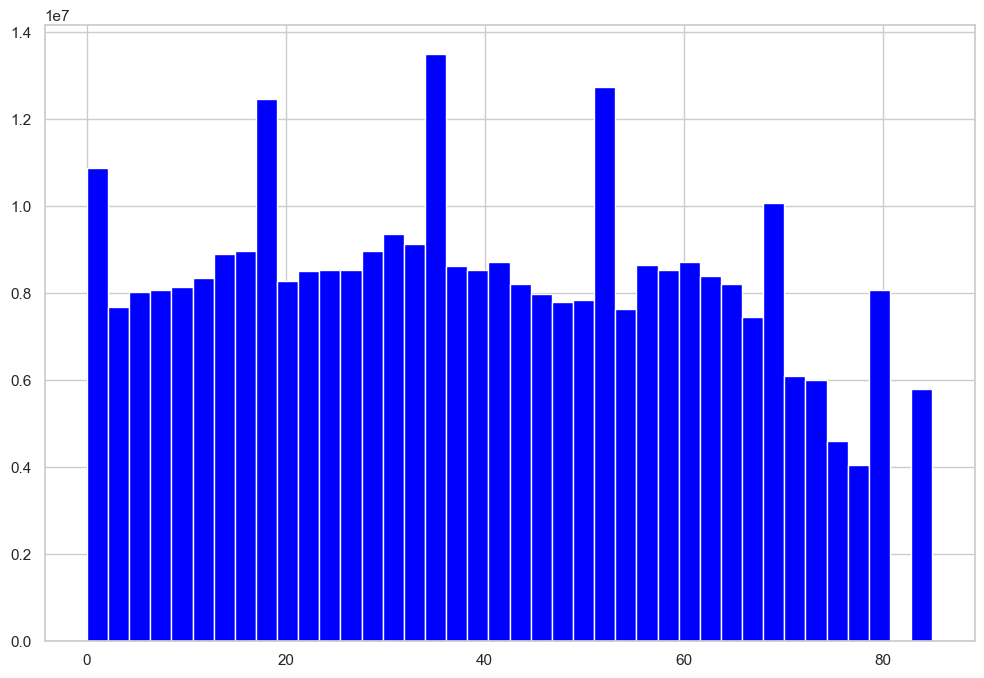

In [94]:
df['AGE'].hist(weights=df['ASECWT'], color='blue', bins=40)

count     121119
unique     35193
top            0
freq       14476
Name: INCTOT_2, dtype: int64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30419/3936798343.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['${:,}'.format(int(x)) for x in ax.get_xticks().tolist()])


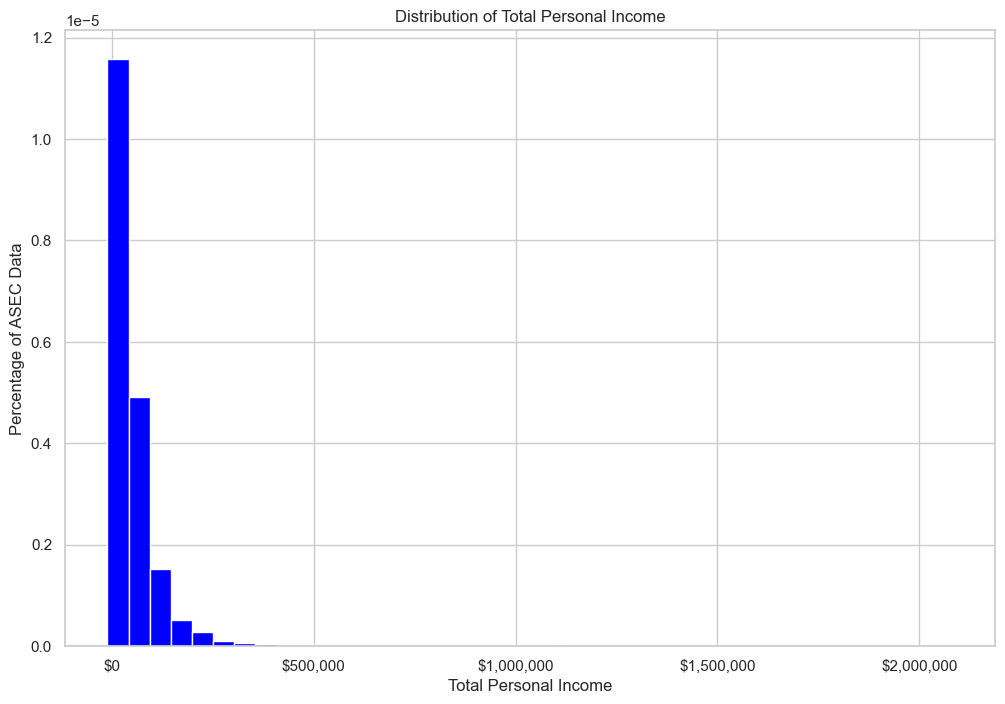

count     121119
unique      3543
top            0
freq       49692
Name: INCWAGE_2, dtype: int64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30419/3936798343.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['${:,}'.format(int(x)) for x in ax.get_xticks().tolist()])


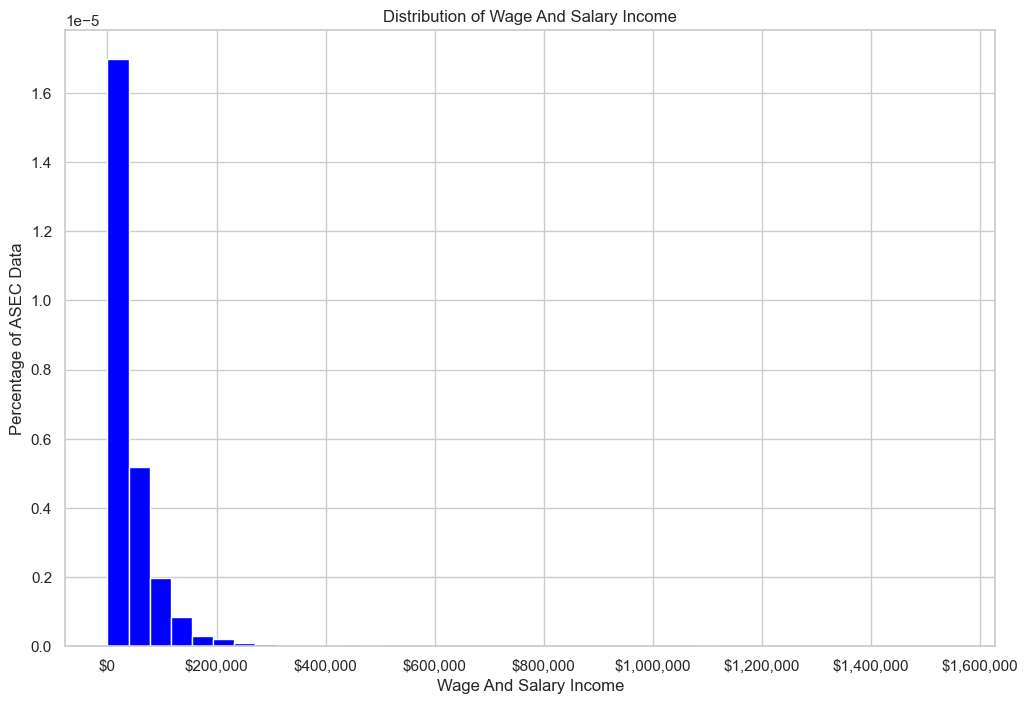

count     121119
unique       403
top            0
freq      115395
Name: INCBUS_2, dtype: int64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30419/3936798343.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['${:,}'.format(int(x)) for x in ax.get_xticks().tolist()])


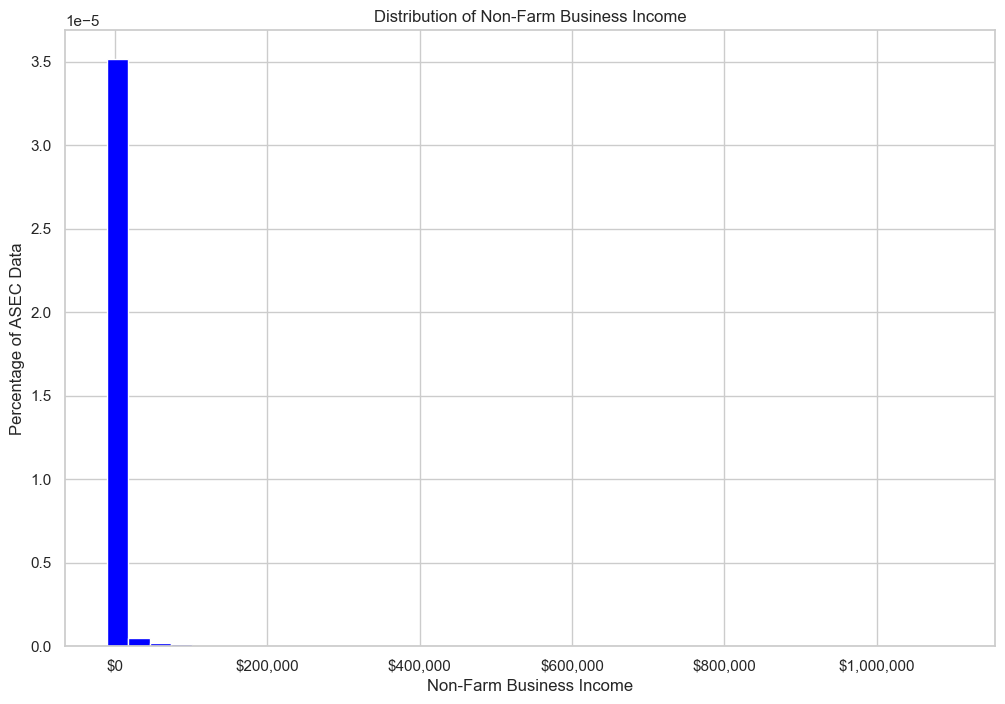

count     121119
unique       111
top            0
freq      120002
Name: INCFARM_2, dtype: int64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30419/3936798343.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['${:,}'.format(int(x)) for x in ax.get_xticks().tolist()])


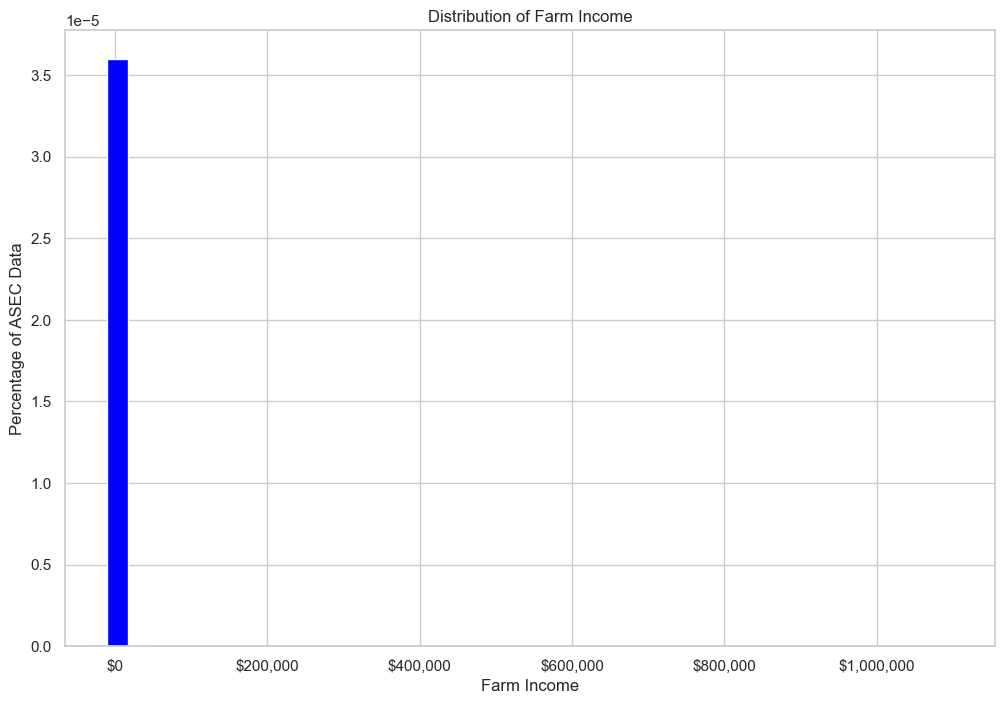

count     121119
unique      4013
top            0
freq       96494
Name: INCSS_2, dtype: int64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30419/3936798343.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['${:,}'.format(int(x)) for x in ax.get_xticks().tolist()])


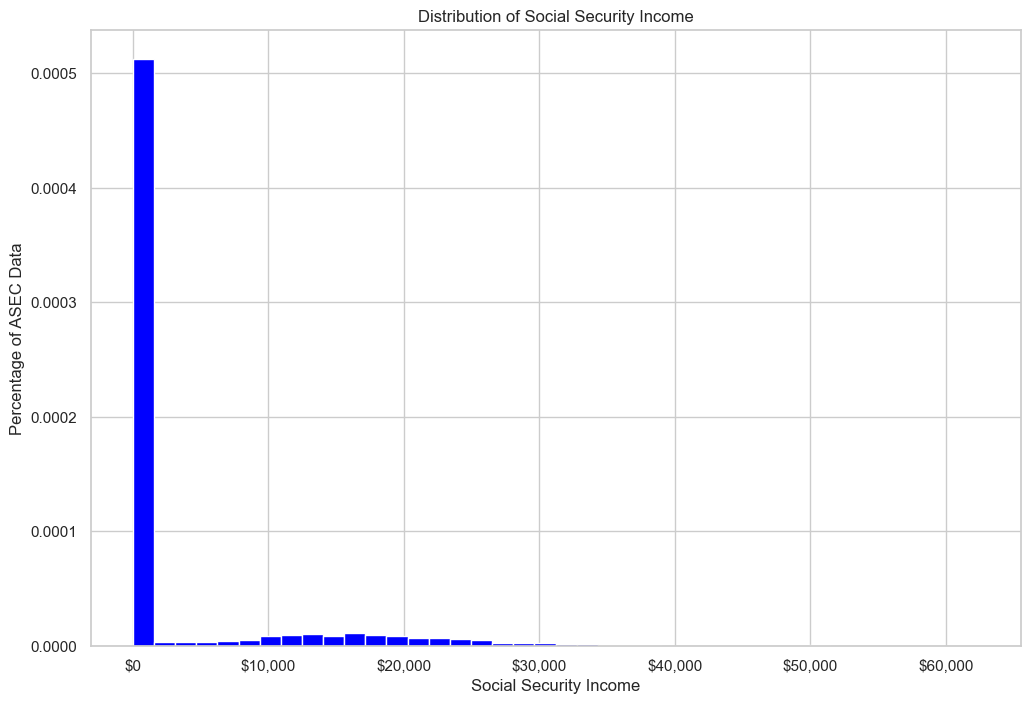

count     121119
unique       224
top            0
freq      120364
Name: INCWELFR_2, dtype: int64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30419/3936798343.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['${:,}'.format(int(x)) for x in ax.get_xticks().tolist()])


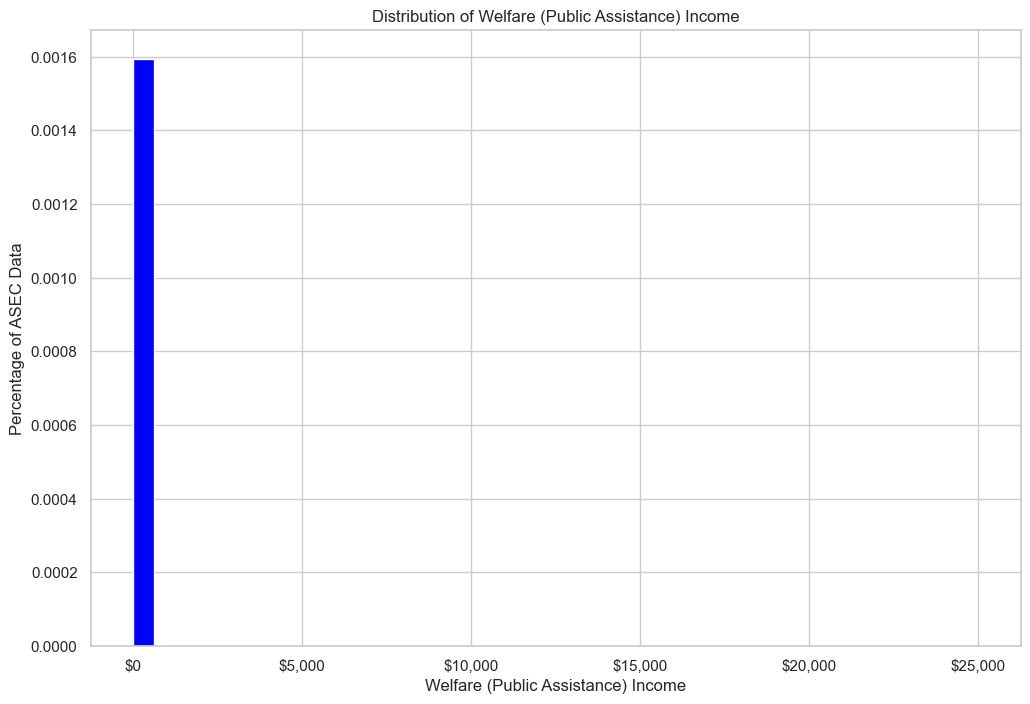

count     152732
unique       695
top            0
freq      148239
Name: INCRETIR_2, dtype: int64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30419/3936798343.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['${:,}'.format(int(x)) for x in ax.get_xticks().tolist()])


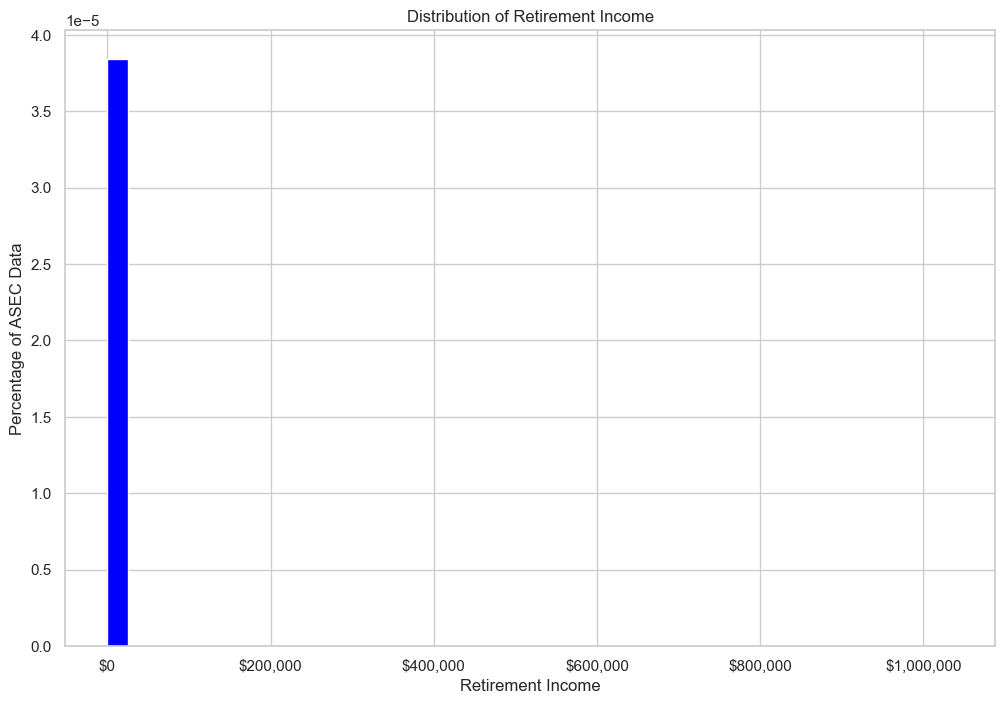

count     121119
unique       583
top            0
freq      118450
Name: INCSSI_2, dtype: int64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30419/3936798343.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['${:,}'.format(int(x)) for x in ax.get_xticks().tolist()])


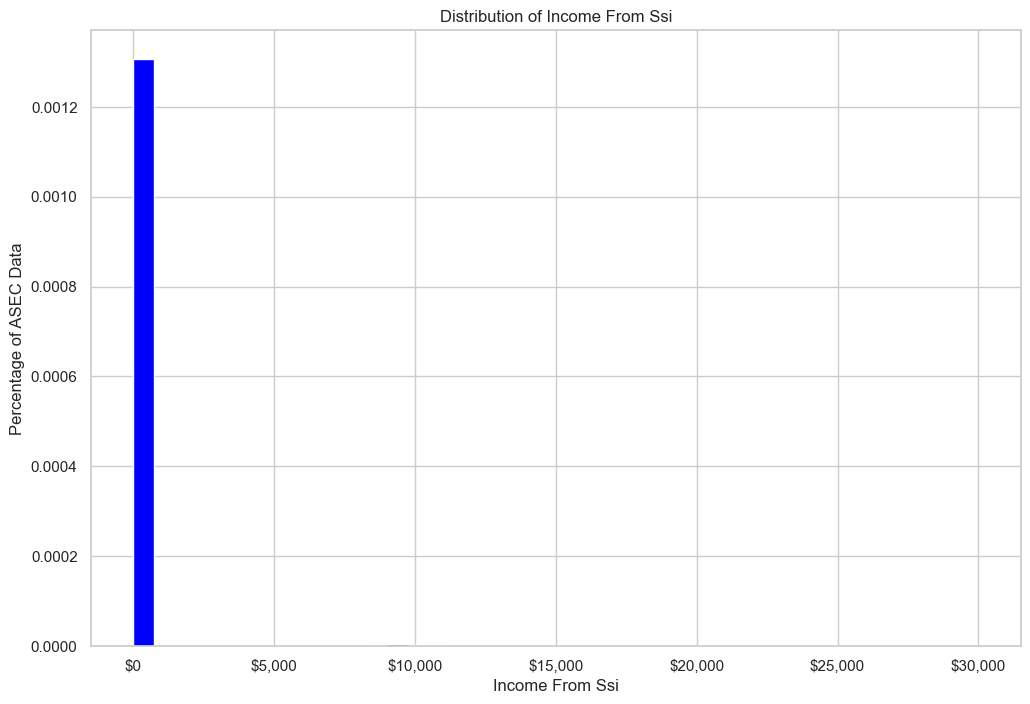

count     121119
unique      6135
top            0
freq       54668
Name: INCINT_2, dtype: int64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30419/3936798343.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['${:,}'.format(int(x)) for x in ax.get_xticks().tolist()])


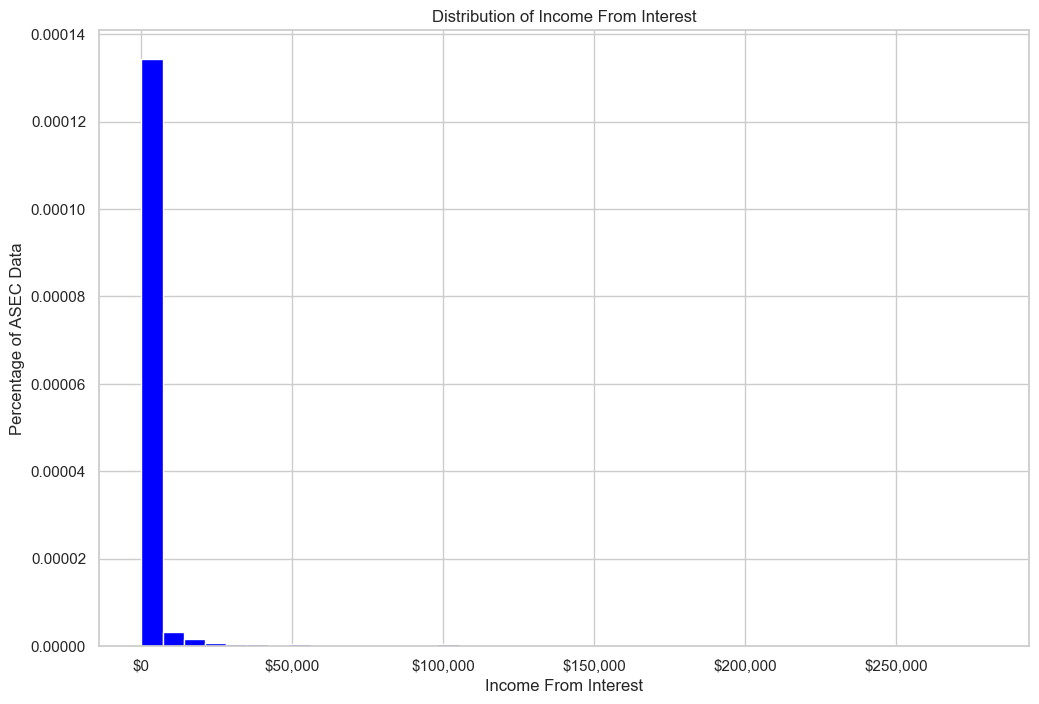

count     121119
unique       941
top            0
freq      117054
Name: INCUNEMP_2, dtype: int64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30419/3936798343.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['${:,}'.format(int(x)) for x in ax.get_xticks().tolist()])


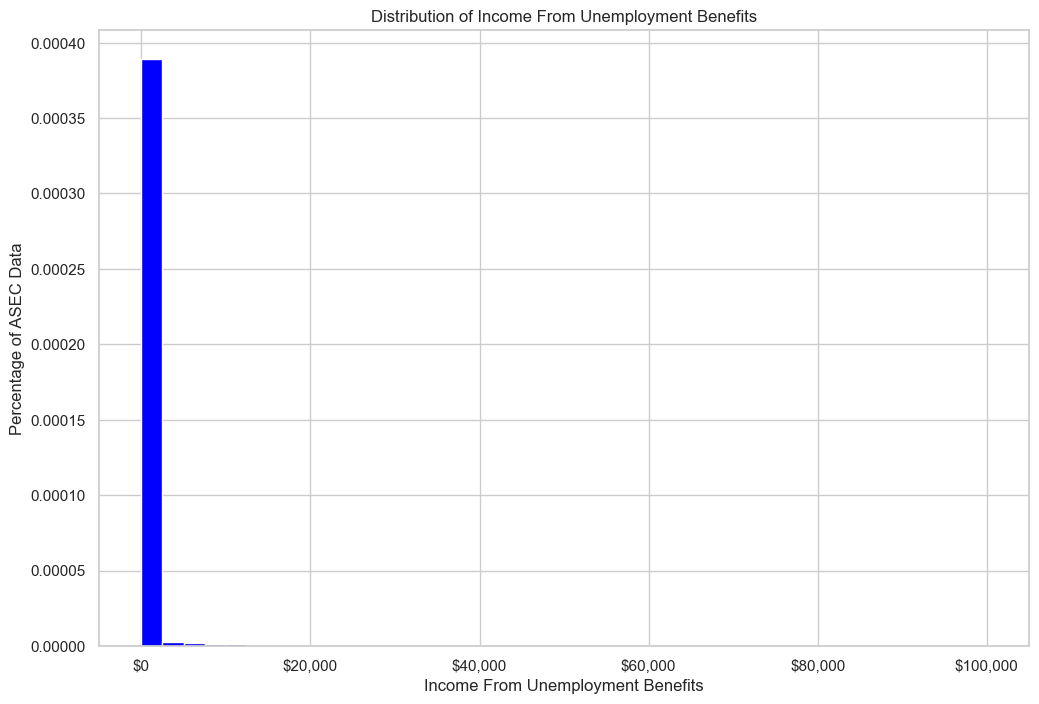

count     121119
unique       152
top            0
freq      120695
Name: INCWKCOM_2, dtype: int64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30419/3936798343.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['${:,}'.format(int(x)) for x in ax.get_xticks().tolist()])


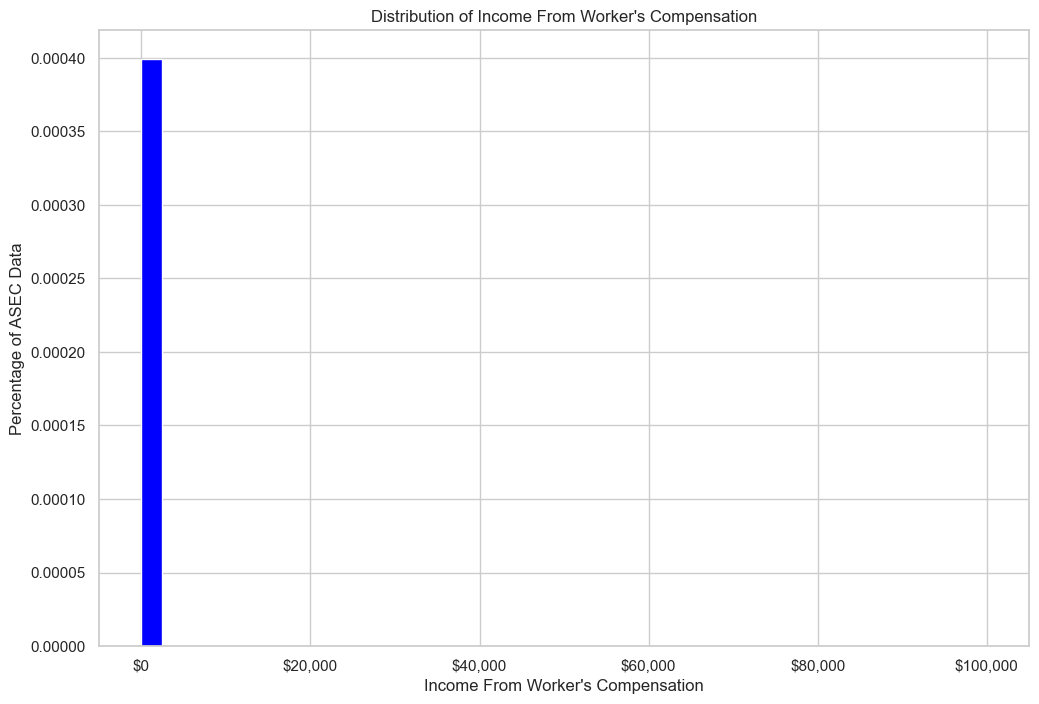

count     121119
unique       482
top            0
freq      118952
Name: INCVET_2, dtype: int64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30419/3936798343.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['${:,}'.format(int(x)) for x in ax.get_xticks().tolist()])


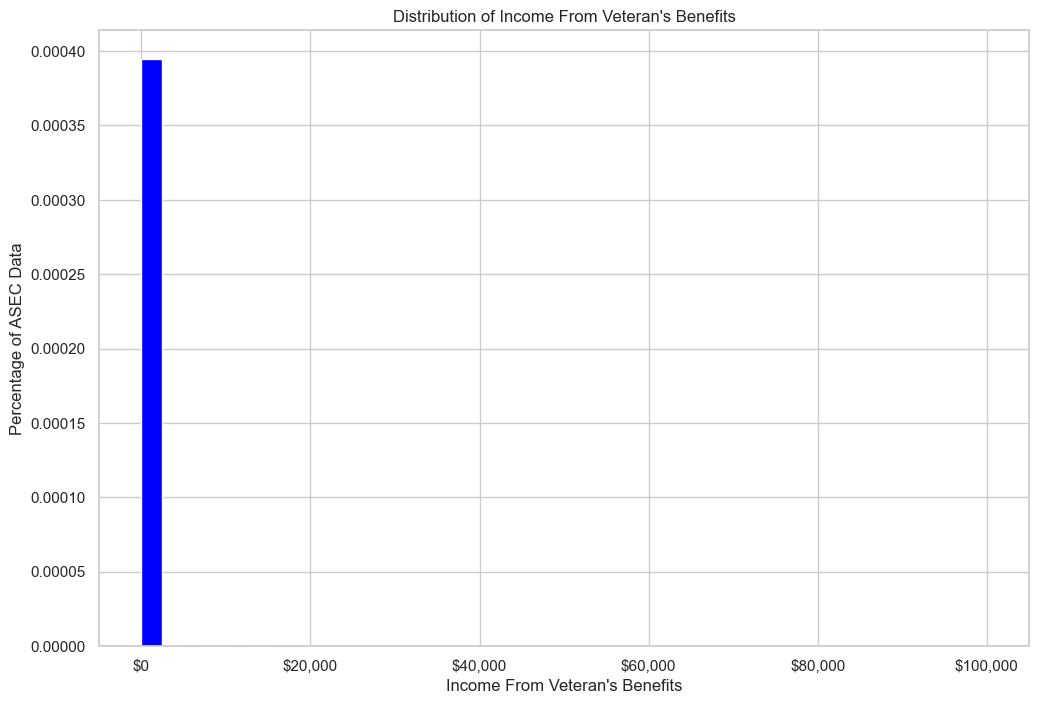

count     121119
unique       391
top            0
freq      119762
Name: INCSURV_2, dtype: int64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30419/3936798343.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['${:,}'.format(int(x)) for x in ax.get_xticks().tolist()])


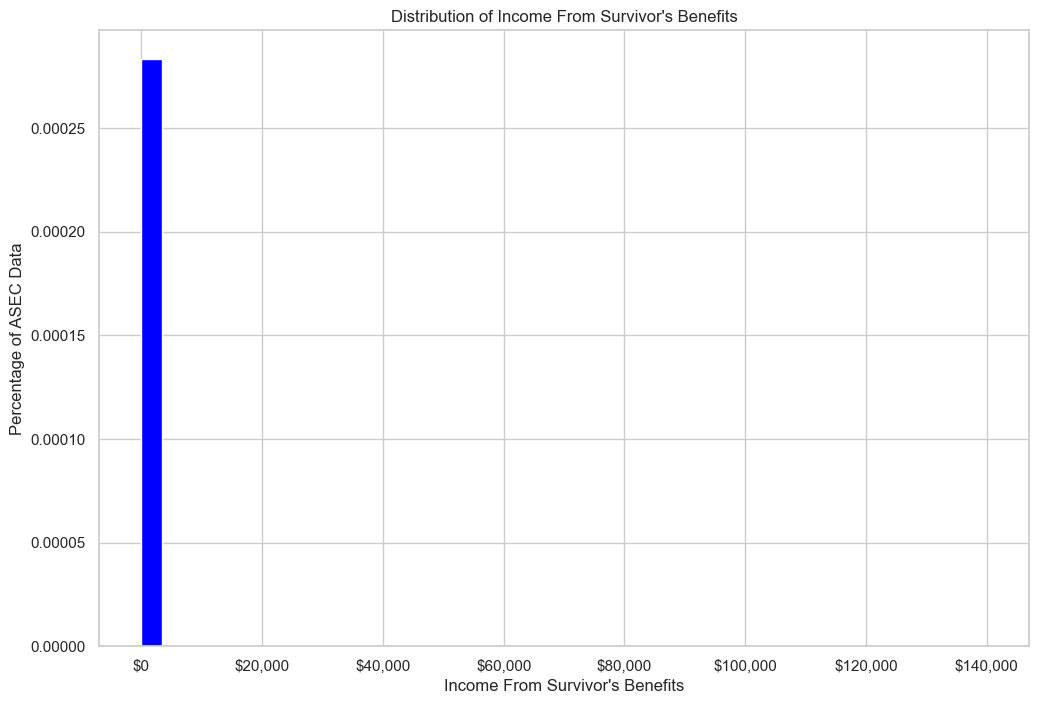

count     121119
unique       315
top            0
freq      119956
Name: INCDISAB_2, dtype: int64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30419/3936798343.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['${:,}'.format(int(x)) for x in ax.get_xticks().tolist()])


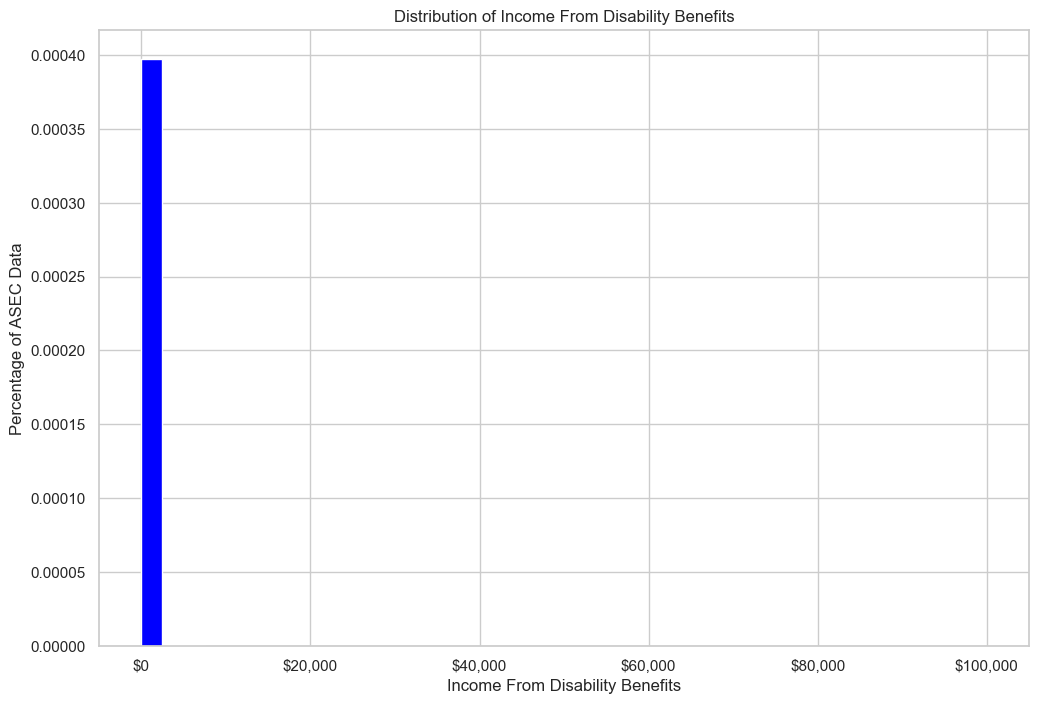

count     121119
unique       480
top            0
freq      104418
Name: INCDIVID_2, dtype: int64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30419/3936798343.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['${:,}'.format(int(x)) for x in ax.get_xticks().tolist()])


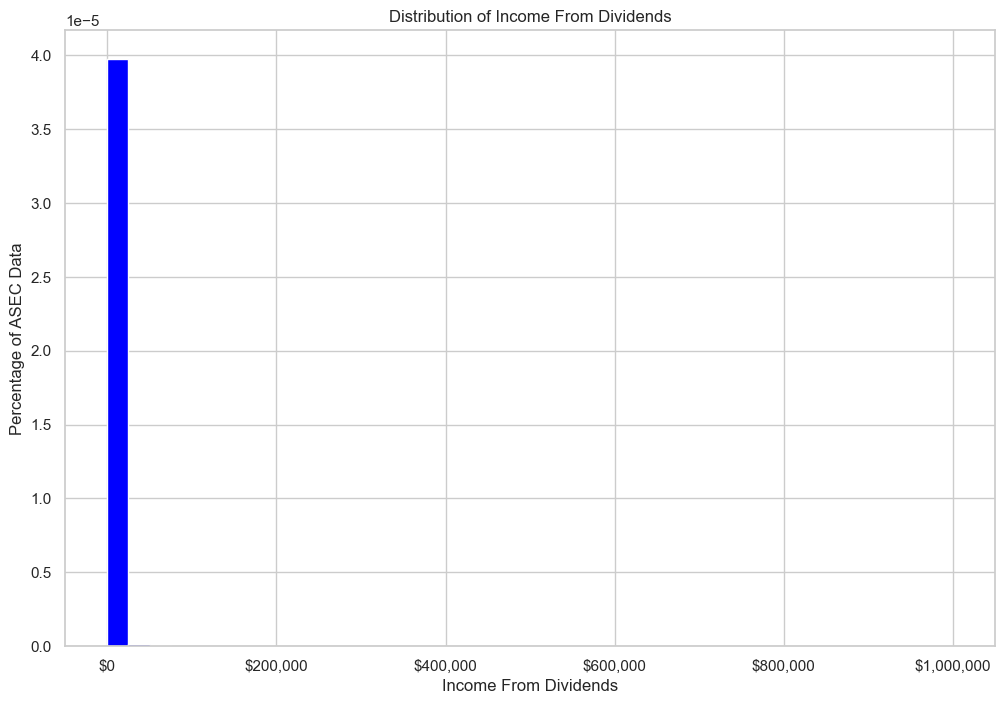

count     121119
unique       377
top            0
freq      115548
Name: INCRENT_2, dtype: int64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30419/3936798343.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['${:,}'.format(int(x)) for x in ax.get_xticks().tolist()])


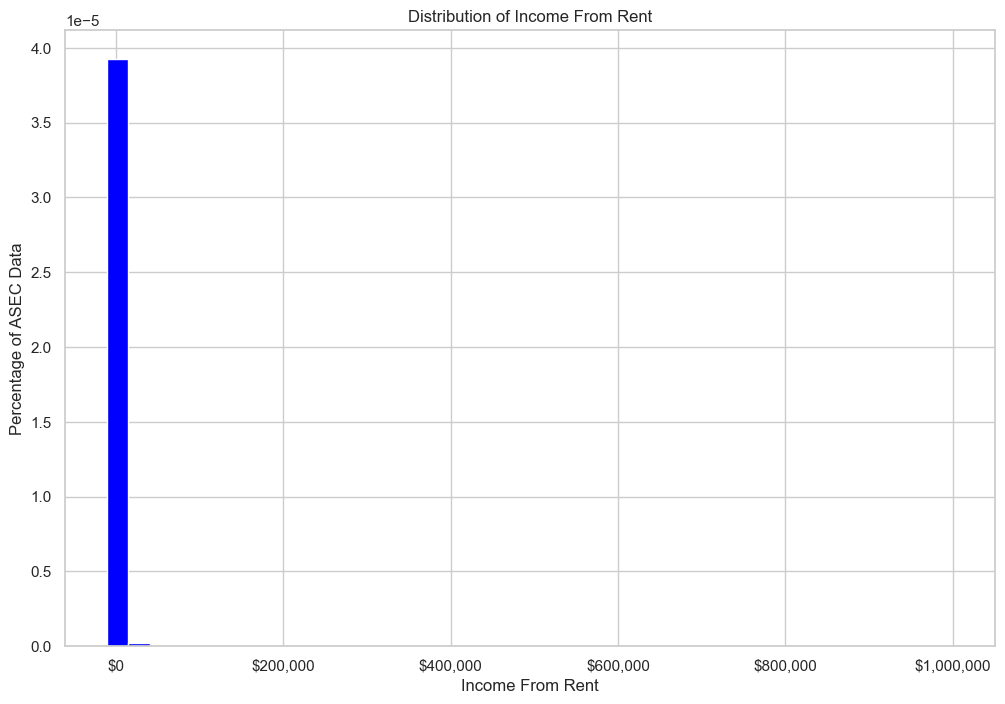

count     121119
unique       278
top            0
freq      118069
Name: INCEDUC_2, dtype: int64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30419/3936798343.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['${:,}'.format(int(x)) for x in ax.get_xticks().tolist()])


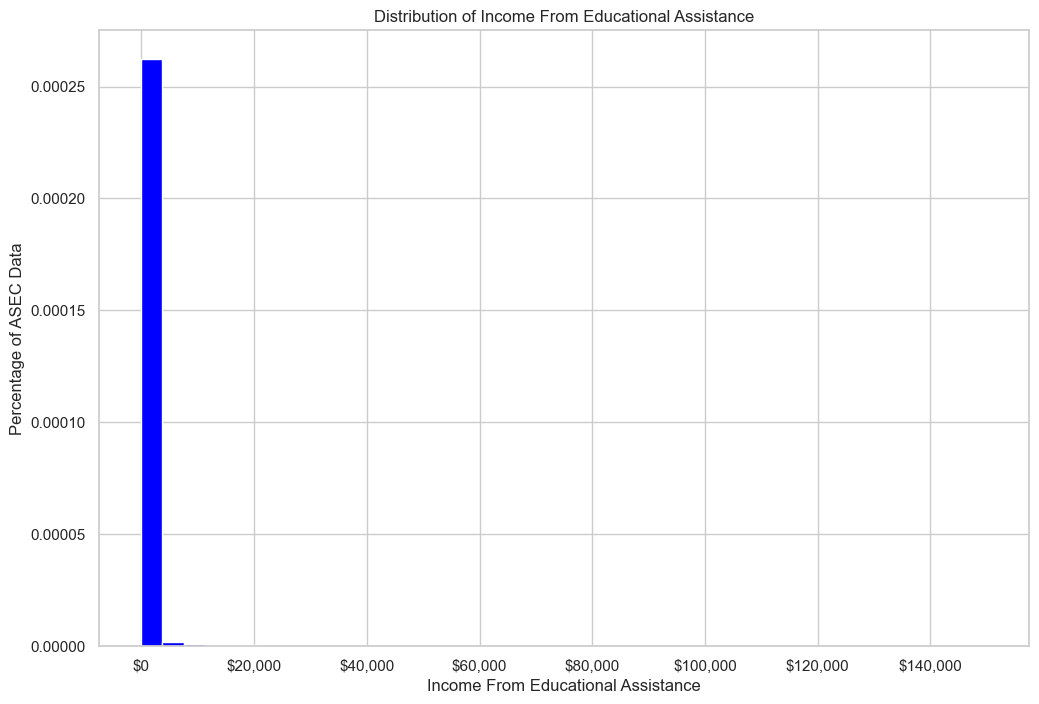

count     121119
unique       447
top            0
freq      119308
Name: INCCHILD_2, dtype: int64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30419/3936798343.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['${:,}'.format(int(x)) for x in ax.get_xticks().tolist()])


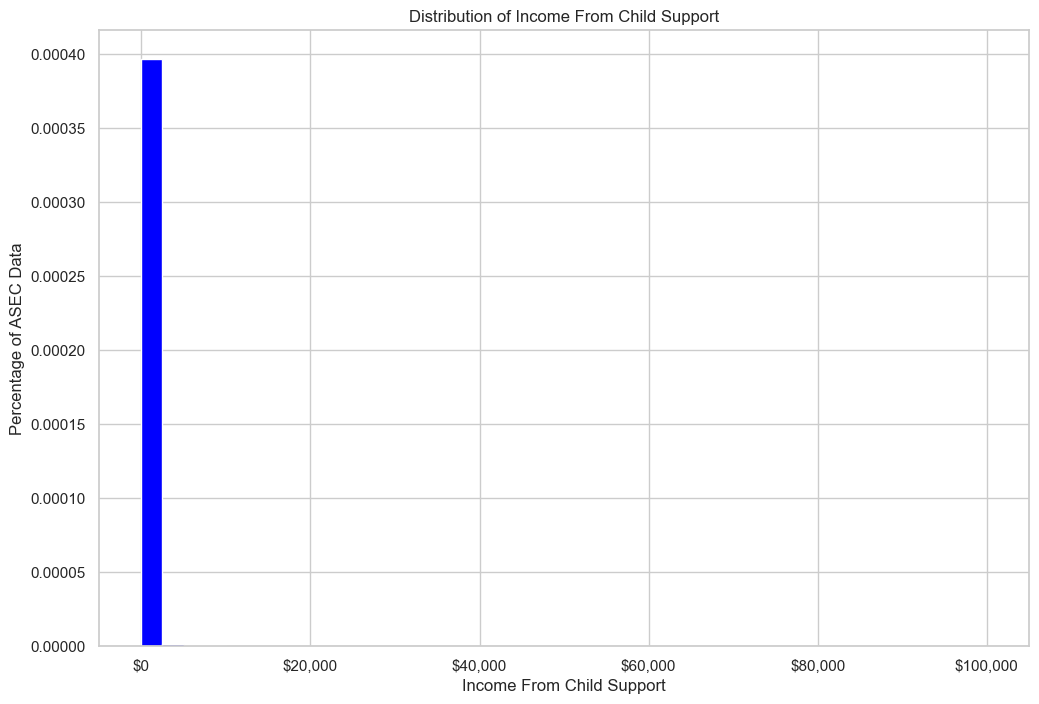

count     121119
unique       133
top            0
freq      120073
Name: INCASIST_2, dtype: int64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30419/3936798343.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['${:,}'.format(int(x)) for x in ax.get_xticks().tolist()])


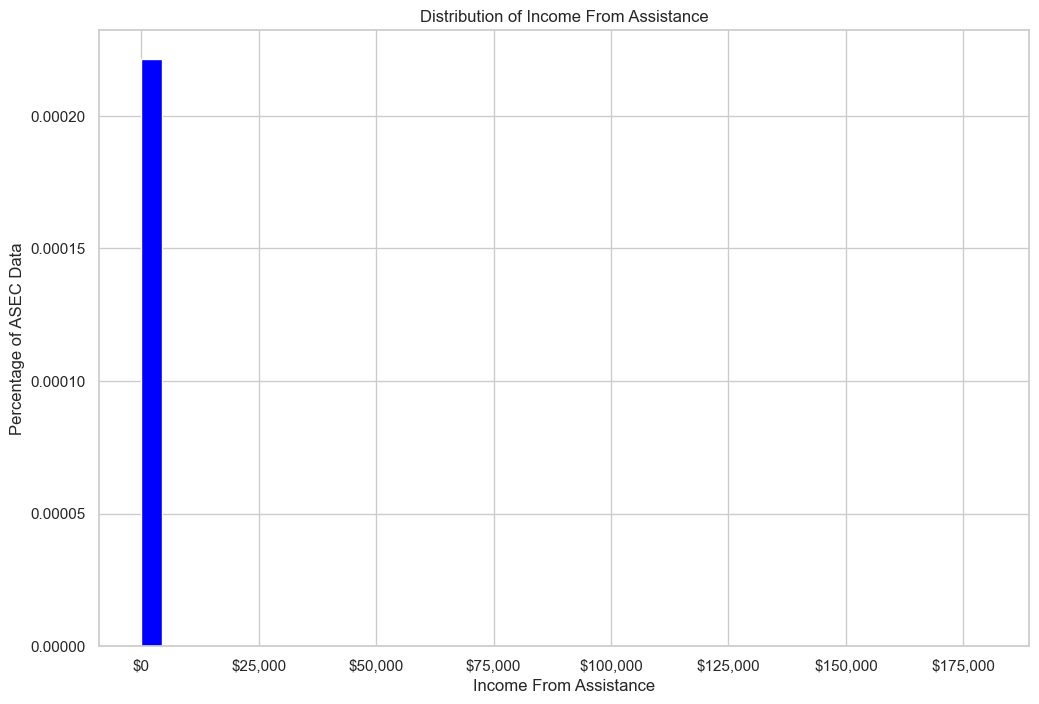

count     152732
unique       212
top            0
freq      151486
Name: INCOTHER_2, dtype: int64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30419/3936798343.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['${:,}'.format(int(x)) for x in ax.get_xticks().tolist()])


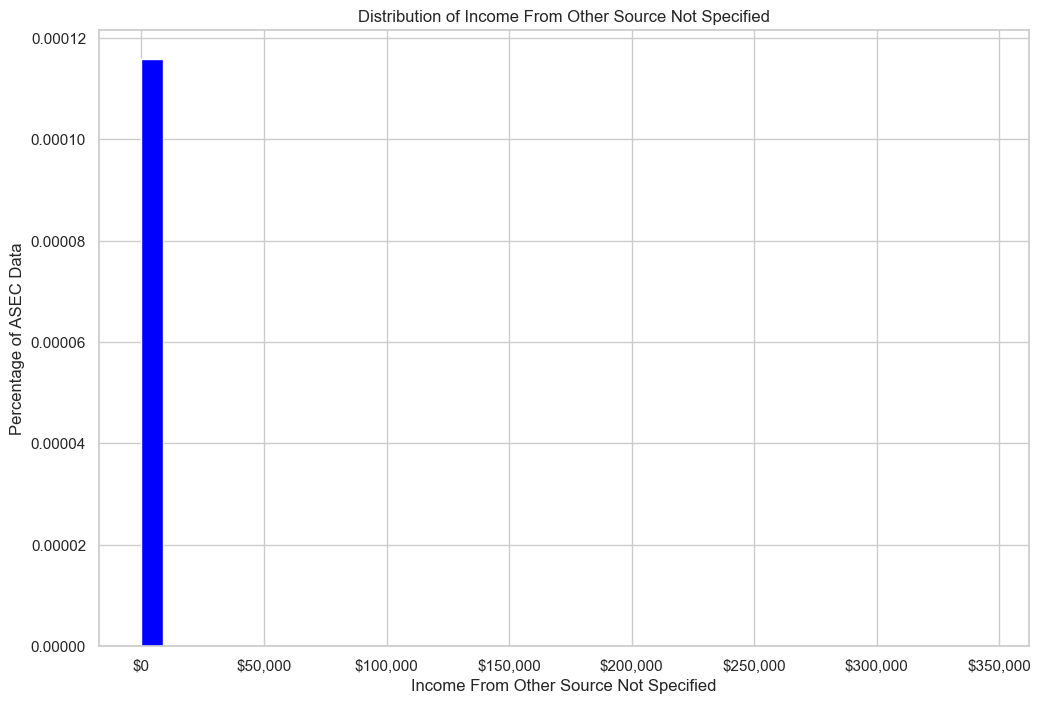

count     152730
unique       349
top            0
freq      150982
Name: INCRANN_2, dtype: int64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30419/3936798343.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['${:,}'.format(int(x)) for x in ax.get_xticks().tolist()])


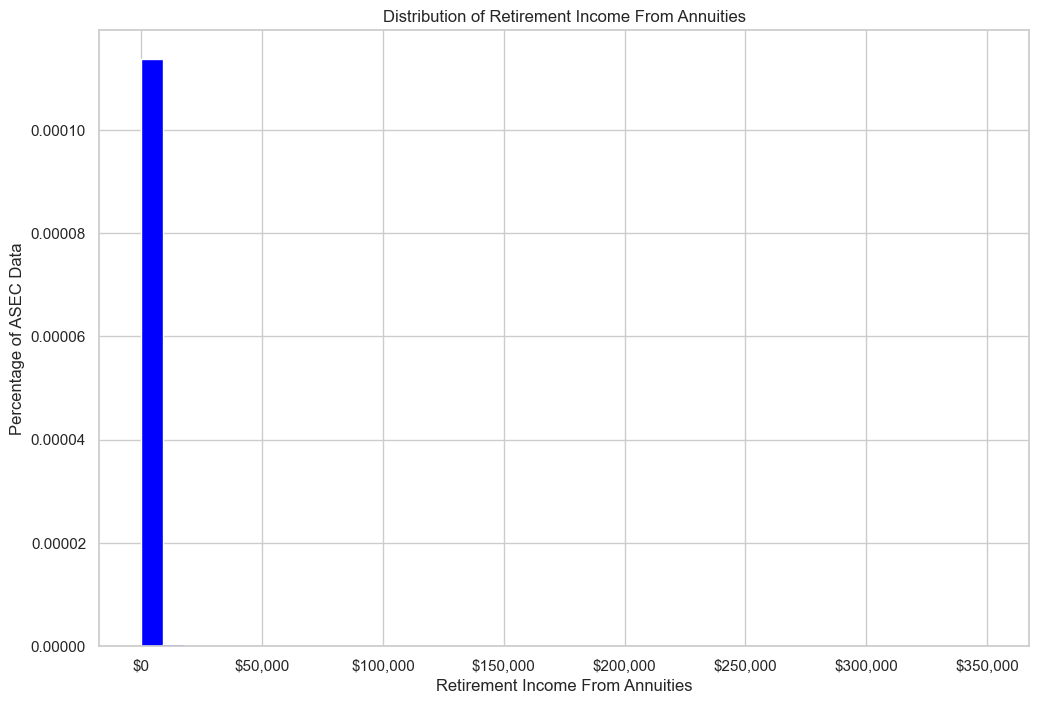

count     152727
unique      1508
top            0
freq      145149
Name: INCPENS_2, dtype: int64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30419/3936798343.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['${:,}'.format(int(x)) for x in ax.get_xticks().tolist()])


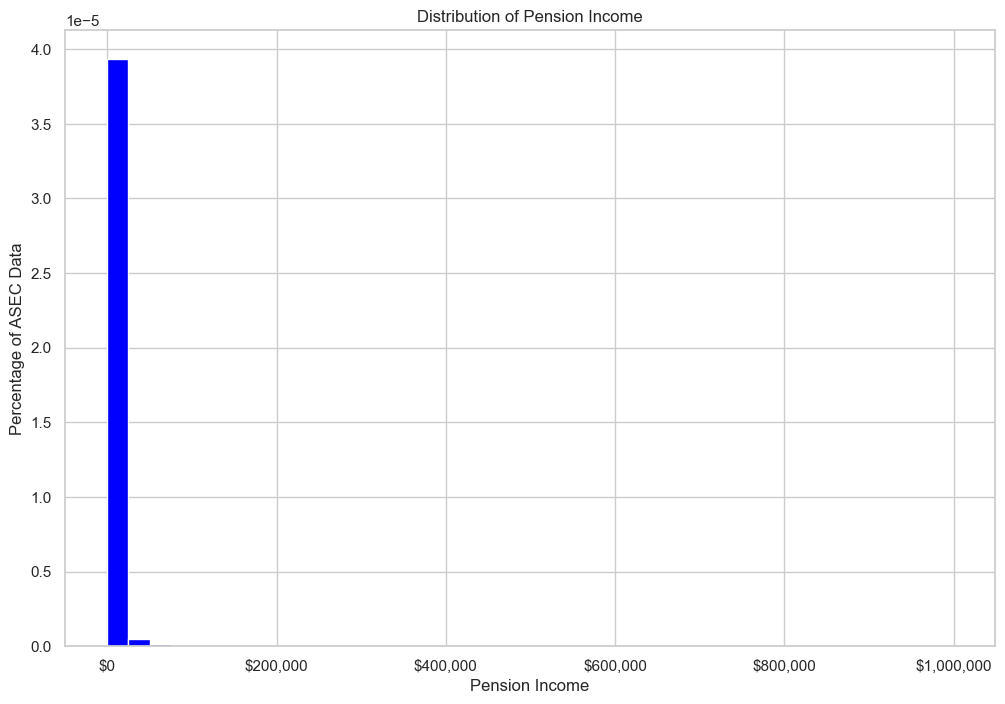

count     121119
unique     33021
top            0
freq       50201
Name: ADJGINC_2, dtype: int64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30419/3936798343.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['${:,}'.format(int(x)) for x in ax.get_xticks().tolist()])


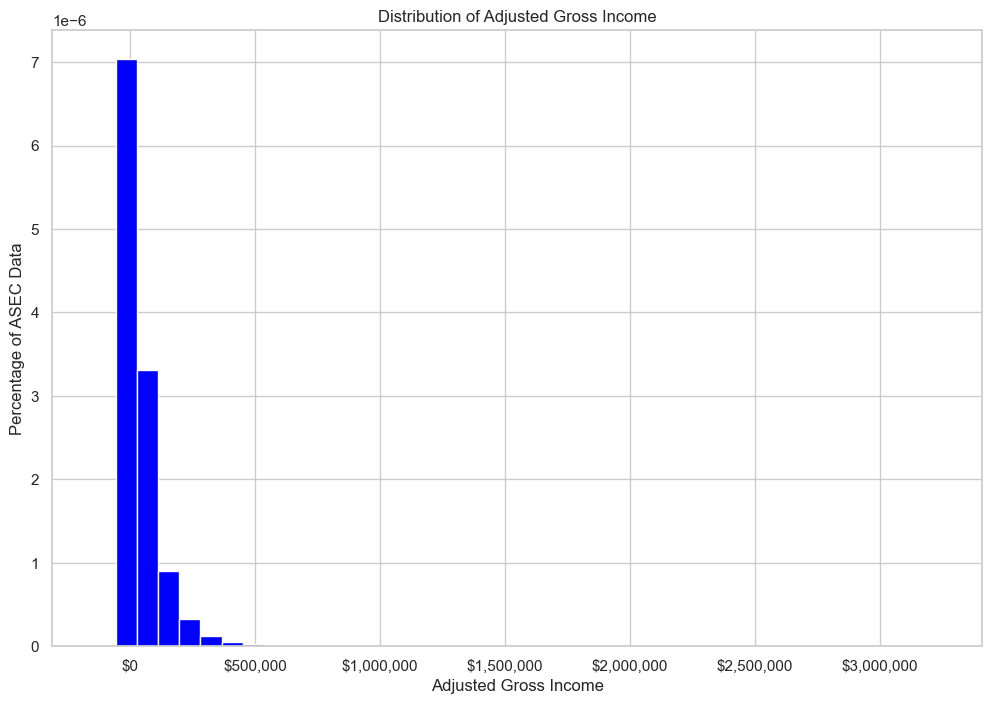

count     121119
unique     31994
top            0
freq       65094
Name: TAXINC_2, dtype: int64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30419/3936798343.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['${:,}'.format(int(x)) for x in ax.get_xticks().tolist()])


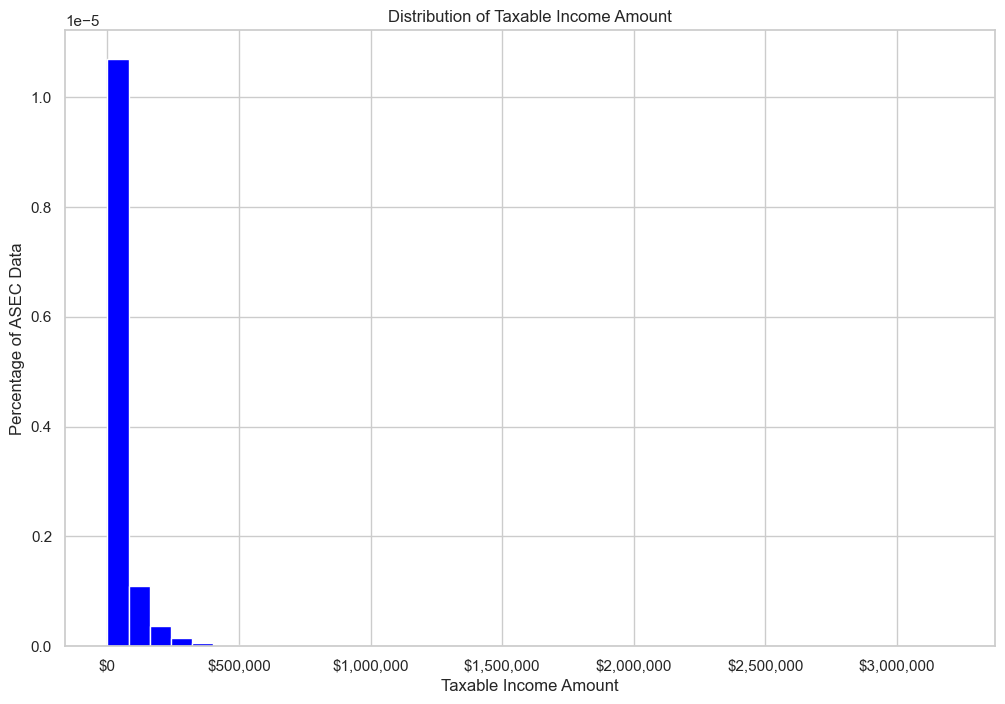

KeyError: 'INCTOT_3_2'

In [95]:
for col in df.columns:
    if 'INC' in col and '2' not in col:
        colname = f"{col}_2"
        f = df[colname].isnull()==False
        print(df.loc[f, colname].describe().round(0))
        ax = df.loc[f, colname].hist(weights=df.loc[f, 'ASECWT'], figsize=(12, 8), color='blue', bins=40, density=True)
        label = ddi_codebook.get_variable_info(col).label.title().replace("'S", "'s")
        ax.set_title(f"Distribution of {label}")
        ax.set_xticklabels(['${:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
        ax.set_xlabel(f"{label}")
        ax.set_ylabel(f"Percentage of ASEC Data")
        plt.show()

In [ ]:
pt(ddi_codebook, df, 'OCC', 'ASECWT')

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set figure size for the notebook
plt.rcParams["figure.figsize"]=12,8
# set seaborn whitegrid theme
sns.set(style="whitegrid")

In [149]:
from IPython.core.display import display

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30419/1726750586.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


In [164]:
import seaborn as sns
def cdf_plot_by_x(
    xdf,
    groupbyvar,
    xvar,
    wvar,
    k=None,
    bbox=(0.5, -0.1),
    legend_ncol=3,
    max_percentile=1.,
):
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    if k is not None:
        sdf = xdf[groupbyvar].value_counts()
        top_k = sdf[0:(k-1)].index.tolist()
        xdfss = xdf[xdf.eval(f'{groupbyvar} == "' + f'" | {groupbyvar} == "'.join(top_k) + '"')].reset_index(drop=True)
        print(f'reducing records from {xdf.shape[0]} to {xdfss.shape[0]}')
        print(f"reducing groups from {xdf[groupbyvar].nunique()} to {k}")
    else:
        xdfss = xdf
    
    max_percentile_value = xdfss[xvar].quantile(max_percentile)
    xdfss = xdfss[xdfss[xvar] < max_percentile_value]
    groups = xdfss[groupbyvar].unique()
    pal = sns.color_palette("bright", len(groups))
    sns.ecdfplot(
        data=xdfss,
        weights=wvar, 
        x=xvar, 
        hue=groupbyvar, 
        alpha=0.8, 
        ax=ax,
        palette=pal,
    ).set(title=f'Cumulative Distribution of Total Income by {groupbyvar}')
    label = ddi_codebook.get_variable_info(xvar.replace("_2", "")).label.title().replace("'S", "'s")
    ax.set_xlabel(f"{label}")
    ax.set_ylabel(f"Cumulative Percent of ASEC Data")
    ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.2f}'))
    ax.get_xaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
    ax.get_legend().set_visible(False)
    fig.legend(labels=groups, loc='lower center', bbox_to_anchor=bbox, ncol=legend_ncol)
    fig.show()
    
def den_cdf_plot_by_x(
    xdf,
    groupbyvar,
    xvar,
    wvar,
    k=None,
    bbox=(0.5, -0.1),
    legend_ncol=3,
    max_percentile=1.,
):
    fig, (ax1, ax) = plt.subplots(1, 2, figsize=(16, 8))
    if k is not None:
        sdf = xdf[groupbyvar].value_counts()
        top_k = sdf[0:(k-1)].index.tolist()
        xdfss = xdf[xdf.eval(f'{groupbyvar} == "' + f'" | {groupbyvar} == "'.join(top_k) + '"')].reset_index(drop=True)
        print(f'reducing records from {xdf.shape[0]} to {xdfss.shape[0]}')
        print(f"reducing groups from {xdf[groupbyvar].nunique()} to {k}")
    else:
        xdfss = xdf
    
    max_percentile_value = xdfss[xvar].quantile(max_percentile)
    xdfss = xdfss[xdfss[xvar] < max_percentile_value]
    groups = xdfss[groupbyvar].unique()
    pal = sns.color_palette("bright", len(groups))

    sns.kdeplot(
        data=xdfss,
        weights=wvar, 
        x=xvar, 
        hue=groupbyvar, 
        cut=0, fill=True, 
        common_norm=False, 
        alpha=0.2, 
        ax=ax1,
        palette=pal,
    ).set(title=f'Estimated Density Function of Total Income by {groupbyvar}')
    label = ddi_codebook.get_variable_info(xvar.replace("_2", "")).label.title().replace("'S", "'s")
    ax1.set_xlabel(f"{label}")
    ax1.set_ylabel(f"Percent of ASEC Data")
    ax1.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.2f}'))
    ax1.get_xaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
    ax1.get_legend().set_visible(False)

    sns.ecdfplot(
        data=xdfss,
        weights=wvar, 
        x=xvar, 
        hue=groupbyvar, 
        alpha=0.8, 
        ax=ax,
        palette=pal,
    ).set(title=f'Cumulative Distribution of Total Income by {groupbyvar}')
    label = ddi_codebook.get_variable_info(xvar.replace("_2", "")).label.title().replace("'S", "'s")
    ax.set_xlabel(f"{label}")
    ax.set_ylabel(f"Cumulative Percent of ASEC Data")
    ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.3f}'))
    ax.get_xaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
    ax.get_legend().set_visible(False)
    fig.legend(labels=groups, loc='lower center', bbox_to_anchor=bbox, ncol=legend_ncol)
    fig.show()
    
def denbyplot(df, colname, byvar, weightvar):
    f, ax = plt.subplots(1, figsize=(12, 8))
    groups = df[byvar].unique()
    labels = []
    for i, g in enumerate(groups):
        f = (df[colname].isnull()==False) & (df[byvar]==g)    
        ax = df[f][f"{colname}_2"].plot(weight=df[f][weightvar], kind='density', grid=True)
        ax.set_xticklabels(['${:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
    #     ax.set_xlim([0, 1e6])
        label = ddi_codebook.get_variable_info(colname.replace("_2", "")).label.title().replace("'S", "'s")
        labels.append(label)
        ax.set_xlabel(f"{label}")

    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])

    # Put a legend below current axis
    ax.set_ylabel(f"Percentage of ASEC Data")
    ax.legend(labels, 
              loc='upper center', bbox_to_anchor=(0.5, -0.1),
              fancybox=True, shadow=True, ncol=2)
    plt.show()
    
def den_plot_by_x(
    xdf,
    groupbyvar,
    xvar,
    wvar,
    k=None,
    bbox=(0.5, -0.1),
    legend_ncol=3,
    max_percentile=1.,
    addvline=False,
):
    fig, ax1 = plt.subplots(1, 1, figsize=(16, 8))
    if k is not None:
        sdf = xdf[groupbyvar].value_counts()
        top_k = sdf[0:(k-1)].index.tolist()
        xdfss = xdf[xdf.eval(f'{groupbyvar} == "' + f'" | {groupbyvar} == "'.join(top_k) + '"')].reset_index(drop=True)
        print(f'reducing records from {xdf.shape[0]} to {xdfss.shape[0]}')
        print(f"reducing groups from {xdf[groupbyvar].nunique()} to {k}")
    else:
        xdfss = xdf
    
    max_percentile_value = xdfss[xvar].quantile(max_percentile)
    xdfss = xdfss[xdfss[xvar] < max_percentile_value]
    groups = xdfss[groupbyvar].unique()
    pal = sns.color_palette("bright", len(groups))

    sns.kdeplot(
        data=xdfss,
        weights=wvar, 
        x=xvar, 
        hue=groupbyvar, 
        cut=0, fill=True, 
        common_norm=False, 
        alpha=0.2, 
        ax=ax1,
        palette=pal,
    ).set(title=f'Estimated Density Function of Total Income by {groupbyvar}')
    label = ddi_codebook.get_variable_info(xvar.replace("_2", "")).label.title().replace("'S", "'s")
    ax1.set_xlabel(f"{label}")
    ax1.set_ylabel(f"Percent of ASEC Data")
    ax1.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.2f}'))
    ax1.get_xaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
    ax1.get_legend().set_visible(False)
    fig.legend(labels=groups, loc='lower center', bbox_to_anchor=bbox, ncol=legend_ncol)
    if addvline:
        tmp = xdf[[xvar, groupbyvar, wvar]]
        tmp['XWEIGHT'] = xdf[xvar] * xdf[wvar]
        x = tmp[
            [groupbyvar, 'XWEIGHT', wvar]
        ].groupby(by=groupbyvar).agg({
            'XWEIGHT': [len, np.sum, np.mean], 
            wvar: [np.sum]
        }, as_index=False)

        x.columns = ['_'.join([y for y in j if y != '']) for j in x.columns]
        x['final'] = x['XWEIGHT_sum'] / x[f'{wvar}_sum']
        display(x[['final']].sort_values(by='final', ascending=False))
        for i, xval in enumerate(x['final']):
            ax1.axvline(x = xval,
               ymin = 0, color=pal[i],
               ymax = 1, linestyle='--')
    
    fig.show()


In [166]:
df['Educational Attainment'] = df['Educational_Attainment']

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30419/1403498168.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['XWEIGHT'] = xdf[xvar] * xdf[wvar]


final
Educational Attainment                          
Graduate degree                    124832.508178
Bachelor's degree                   89059.971181
Vocational Degree                   57712.638826
High school diploma or equivalent   48640.595243
Less than High School Diploma        27380.66278

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30419/1403498168.py:191: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


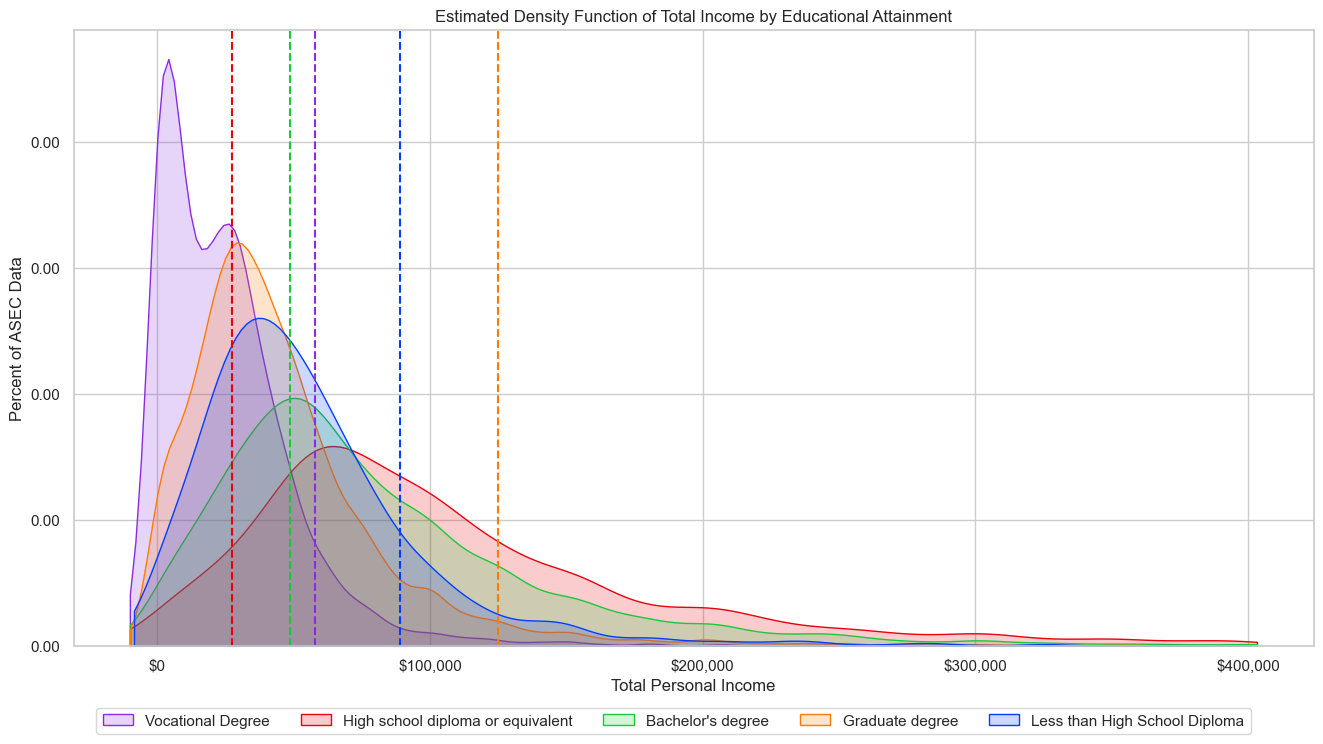

In [167]:
den_plot_by_x(df[df['LABFORCE']==2], 'Educational Attainment', 'INCTOT_2', 'ASECWT', 
                  k=None, bbox=(0.5, -0.01), legend_ncol=10, max_percentile=0.99, addvline=True)

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30419/1403498168.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['XWEIGHT'] = xdf[xvar] * xdf[wvar]


final
Class_of_worker                               
Self-employed, incorporated      118895.396518
Federal government employee       92721.349327
State government employee         68684.927021
Local government employee         66731.595517
Wage/salary, private              66523.726958
Self-employed, not incorporated   58236.788535
Unpaid family worker              15435.825097
NIU                                4277.086577

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30419/1403498168.py:191: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


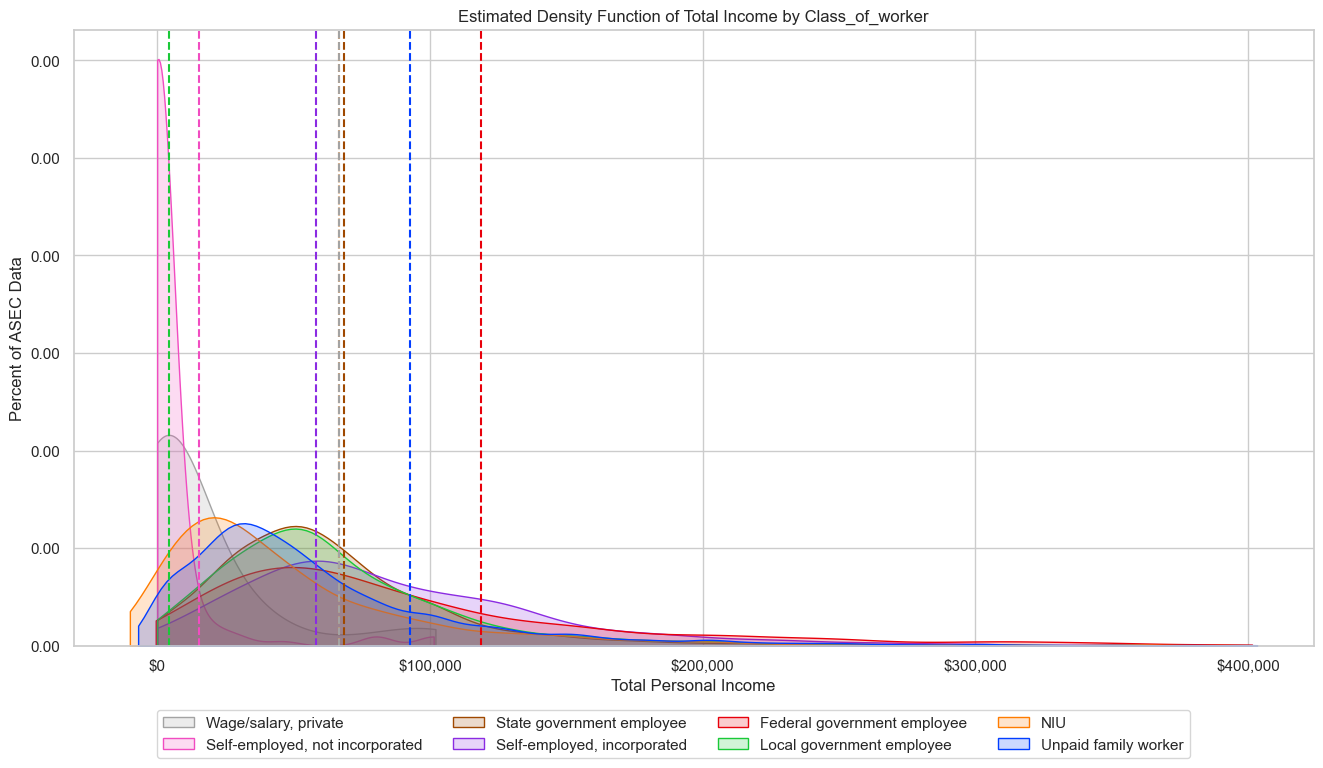

In [171]:
den_plot_by_x(df[df['LABFORCE']==2], 'Class_of_worker', 'INCTOT_2', 'ASECWT', 
                  k=None, bbox=(0.5, -0.04), legend_ncol=4, max_percentile=0.99, addvline=True)

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30419/1403498168.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['XWEIGHT'] = xdf[xvar] * xdf[wvar]


final
Age_bucket                    
Age (61.0, 85.0]  89740.894748
Age (45.0, 61.0]  82221.321794
Age (30.0, 45.0]   72867.29111
Age (14.0, 30.0]  38395.212749

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30419/1403498168.py:191: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


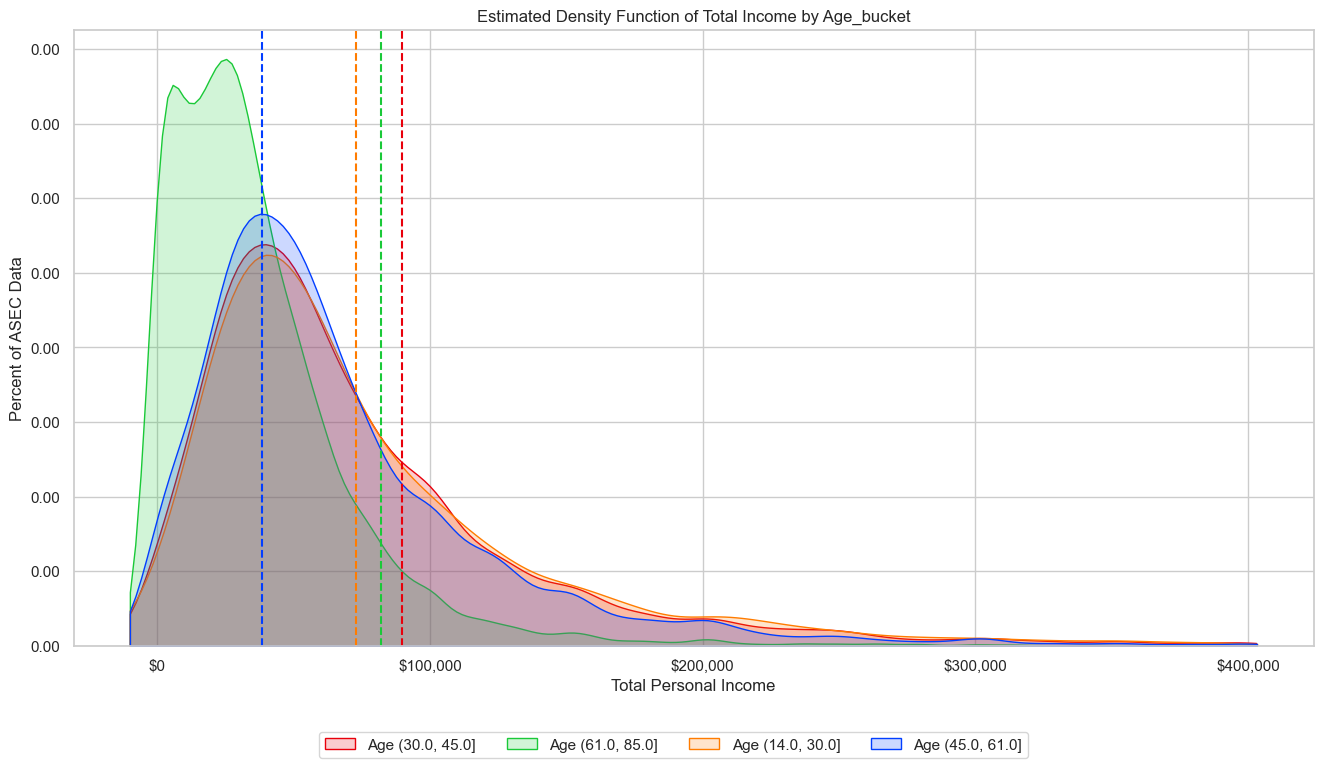

In [174]:
den_plot_by_x(df[df['LABFORCE']==2], 'Age_bucket', 'INCTOT_2', 'ASECWT', 
                  k=None, bbox=(0.5, -0.04), legend_ncol=4, max_percentile=0.99, addvline=True)

reducing records from 73863 to 71682
reducing groups from 26 to 5


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30419/1403498168.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['XWEIGHT'] = xdf[xvar] * xdf[wvar]


final
Race                                                             
American Indian-Asian                               206127.196492
Two or three races, unspecified                     100614.183691
Black-American Indian-Asian                               89000.0
Asian only                                            84912.99215
White-Asian-Hawaiian/Pacific Islander                80907.327043
White                                                70658.560207
White-Asian                                          65564.213848
Asian-Hawaiian/Pacific Islander                      64051.040273
White-Black--Hawaiian/Pacific Islander               61873.432358
Hawaiian/Pacific Islander only                       60418.399751
Black-Asian                                          60046.728053
White-American Indian-Asian                           59574.04126
White-Hawaiian/Pacific Islander                      54300.477419
Black                                                52438.584459
White-Black-American Indian-Asian                    48554.794698
Black-American Indian                                48075.395662
American Indian/Aleut/Eskimo                         46543.253197
White-American Indian                                45051.611256
White-American Indian-Hawaiian/Pacific Islander      43992.605318
White-Black                                          42645.991863
White-Black-American Indian                           41279.16846
White-Black-Asian                                    33577.112001
White-American Indian-Asian-Hawaiian/Pacific Is...   32246.953456
Four or five races, unspecified                      25937.802296
American Indian-Hawaiian/Pacific Islander            22297.014621
Black-Hawaiian/Pacific Islander                      17413.517191

IndexError: list index out of range

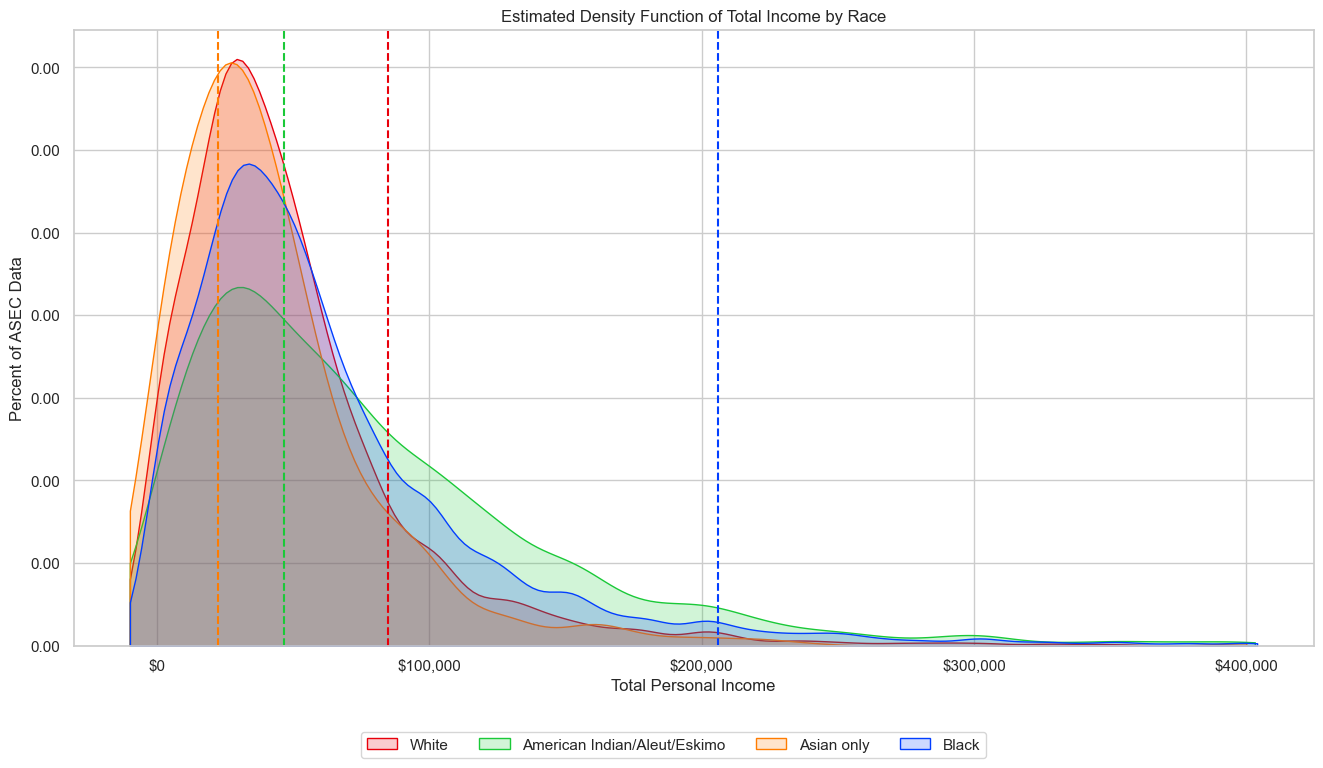

In [175]:
den_plot_by_x(df[df['LABFORCE']==2], 'Race', 'INCTOT_2', 'ASECWT', 
                  k=5, bbox=(0.5, -0.04), legend_ncol=4, max_percentile=0.99, addvline=True)

In [134]:
test = sns.color_palette("bright", 5)

In [136]:
test[0]

(0.00784313725490196, 0.24313725490196078, 1.0)

In [71]:
df['Educational_Attainment'].value_counts(True)

High school diploma or equivalent    0.384693
Missing                              0.206983
Bachelor's degree                    0.160006
Less than High School Diploma        0.120983
Graduate degree                      0.095232
Vocational Degree                    0.032102
Name: Educational_Attainment, dtype: float64

In [108]:
df['WEIGHTED_INCTOT'] = df['INCTOT_2'] * df['ASECWT']

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30419/212720491.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


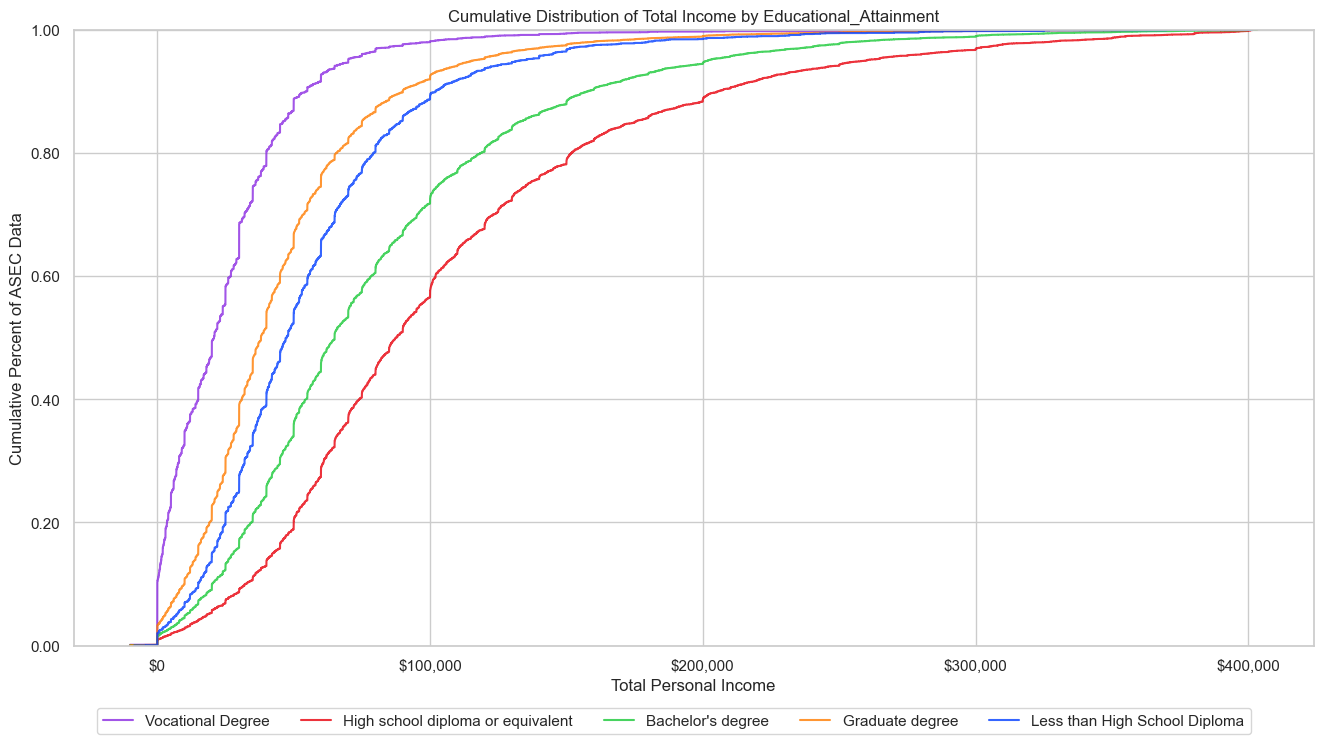

In [98]:
cdf_plot_by_x(df[df['LABFORCE']==2], 'Educational_Attainment', 'INCTOT_2', 'ASECWT', 
                  k=None, bbox=(0.5, -0.01), legend_ncol=10, max_percentile=0.99)

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_59074/331875114.py:149: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


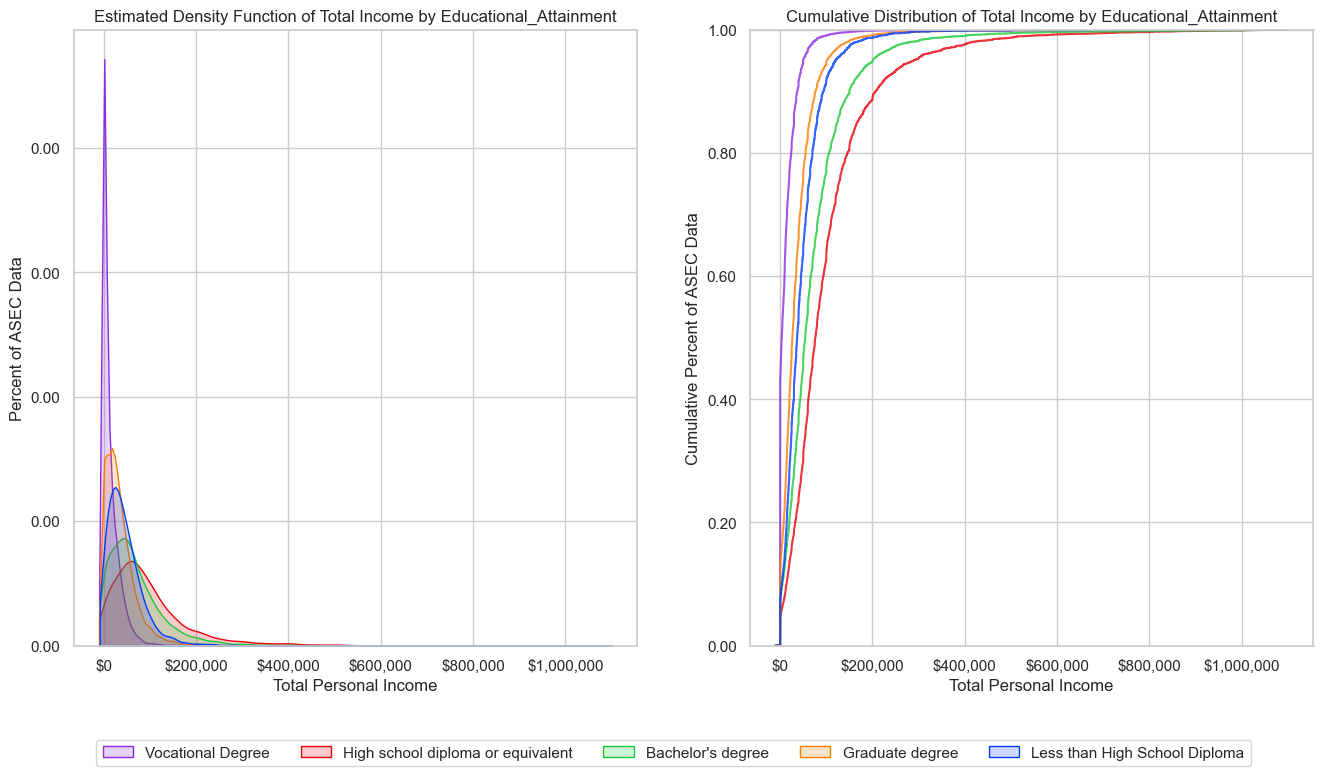

In [66]:
den_cdf_plot_by_x(df, 'Educational_Attainment', 'INCTOT_2', 'ASECWT', 
                  k=None, bbox=(0.5, -0.05), legend_ncol=10, max_percentile=0.999)

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30240/331875114.py:149: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


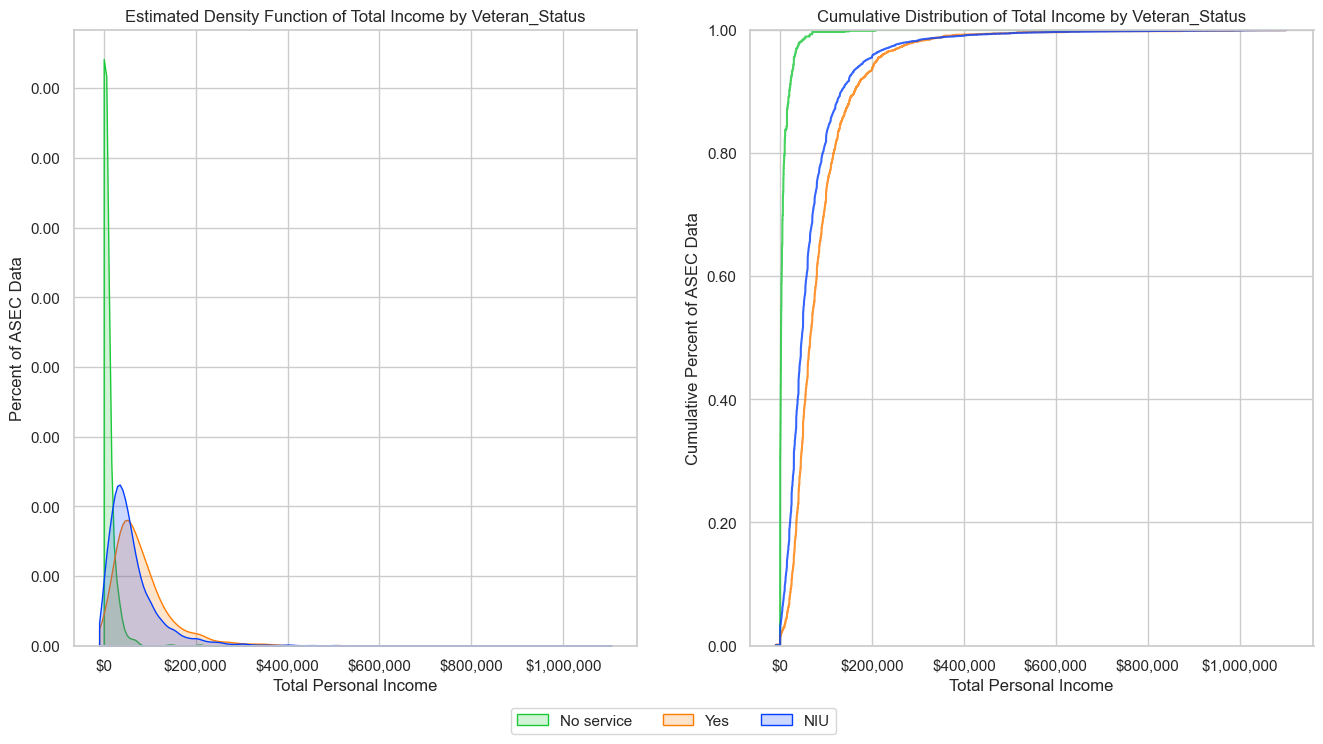

In [83]:
den_cdf_plot_by_x(
    df[df['LABFORCE']==2], 'Veteran_Status', 'INCTOT_2', 'ASECWT', 
    k=None, bbox=(0.5, -0.01), legend_ncol=5, 
    max_percentile=0.999,
)

reducing records from 73863 to 72717
reducing groups from 8 to 6


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30240/331875114.py:149: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


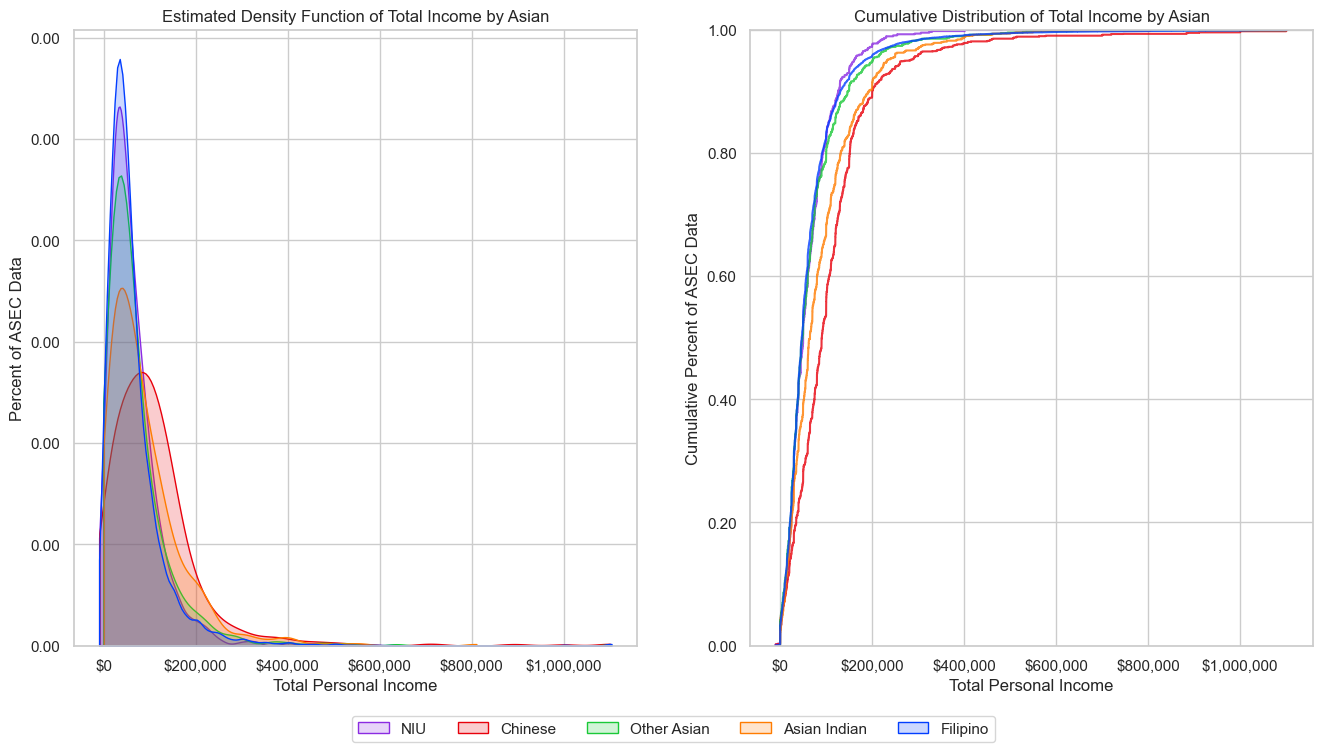

In [87]:
den_cdf_plot_by_x(
    df[df['LABFORCE']==2], 'Asian', 'INCTOT_2', 'ASECWT', k=6, 
    bbox=(0.5, -0.02), legend_ncol=10, max_percentile=0.999,
)

reducing records from 73863 to 71418
reducing groups from 9 to 6


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30240/331875114.py:149: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


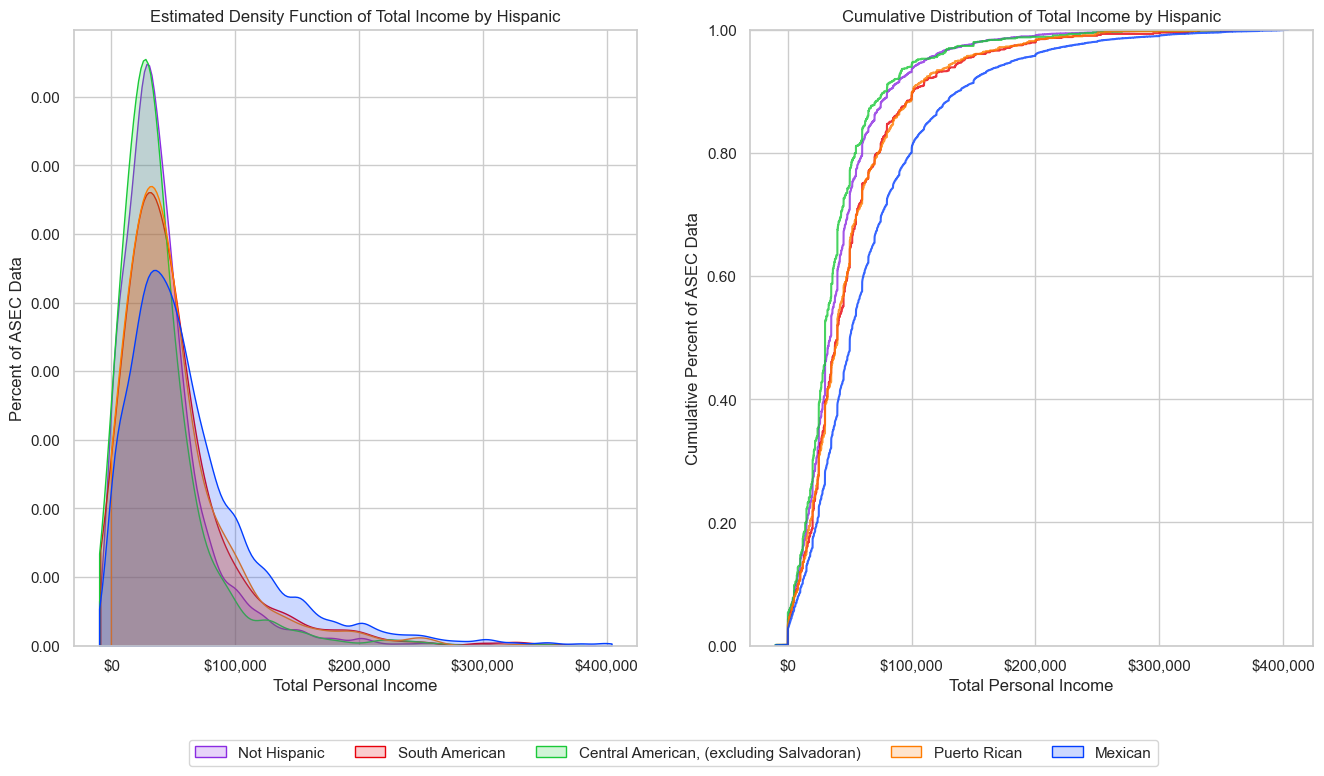

In [86]:
den_cdf_plot_by_x(
    df[df['LABFORCE']==2], 'Hispanic', 'INCTOT_2', 'ASECWT', 
    k=6, bbox=(0.5, -0.05), legend_ncol=5, 
    max_percentile=0.99,
)

reducing records from 73863 to 71486
reducing groups from 8 to 6


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30240/331875114.py:149: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


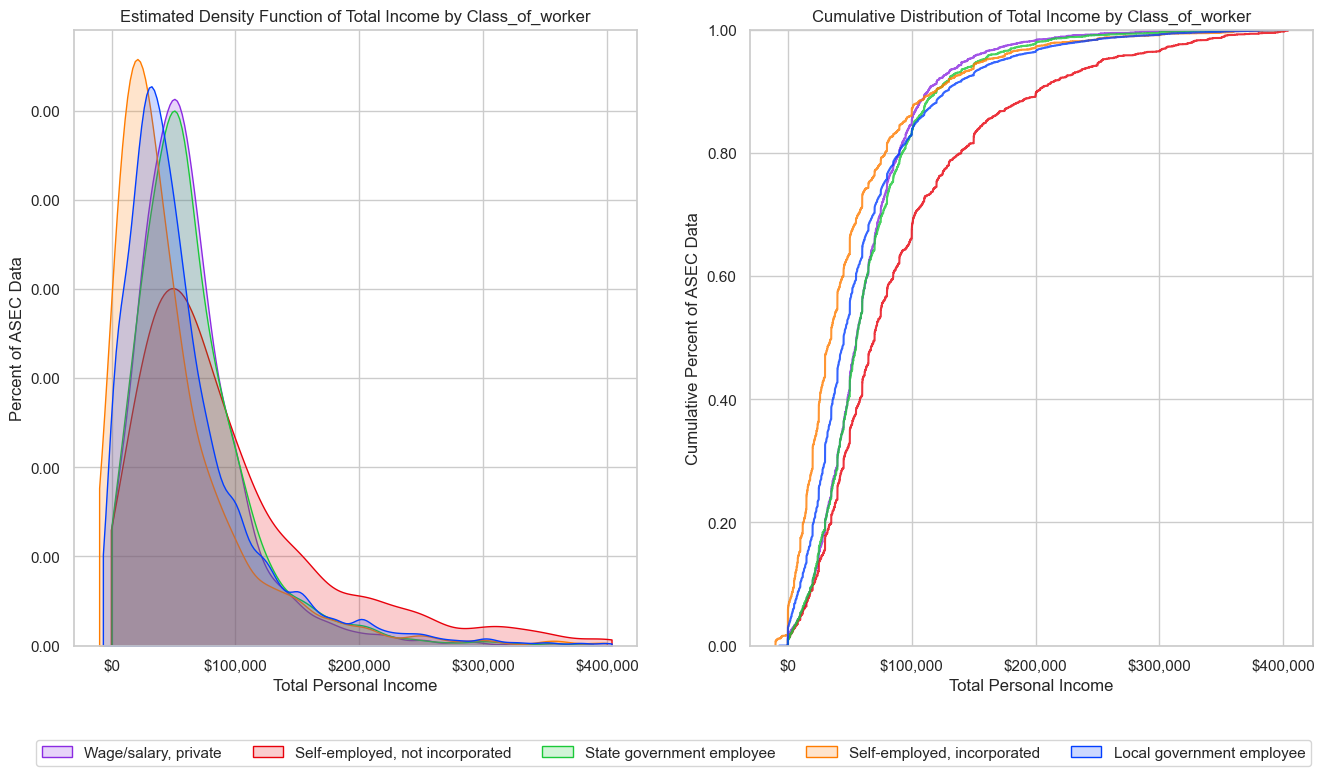

In [88]:
den_cdf_plot_by_x(df[df['LABFORCE']==2], 'Class_of_worker', 'INCTOT_2', 'ASECWT', k=6, bbox=(0.5, -0.05), legend_ncol=5, max_percentile=0.99)

reducing records from 73863 to 72772
reducing groups from 6 to 6


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30240/331875114.py:149: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


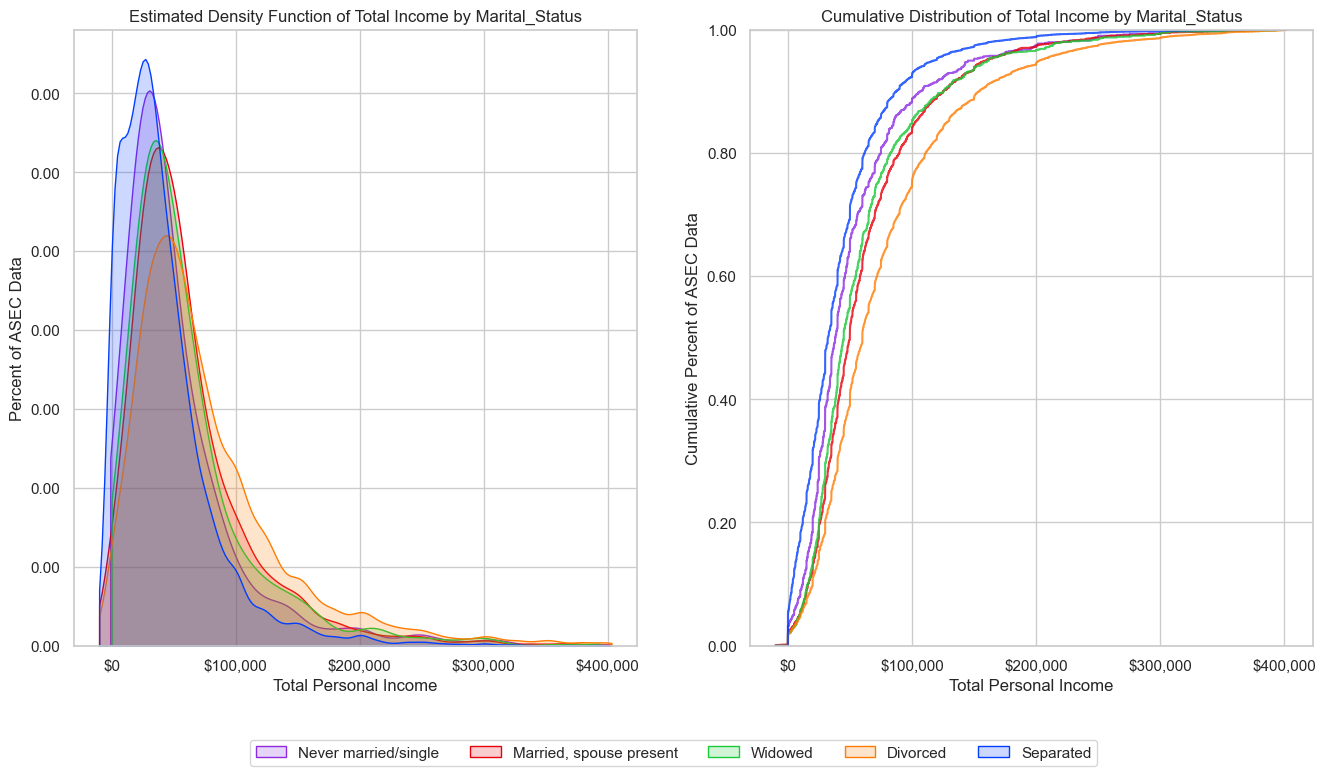

In [89]:
den_cdf_plot_by_x(
    df[df['LABFORCE']==2], 'Marital_Status', 'INCTOT_2', 'ASECWT', k=6, bbox=(0.5, -0.05), 
    legend_ncol=5, max_percentile=0.99
)

In [90]:
df['Age'] = df['AGE'].astype(float)

reducing records from 73863 to 67317
reducing groups from 160 to 10


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30240/331875114.py:149: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


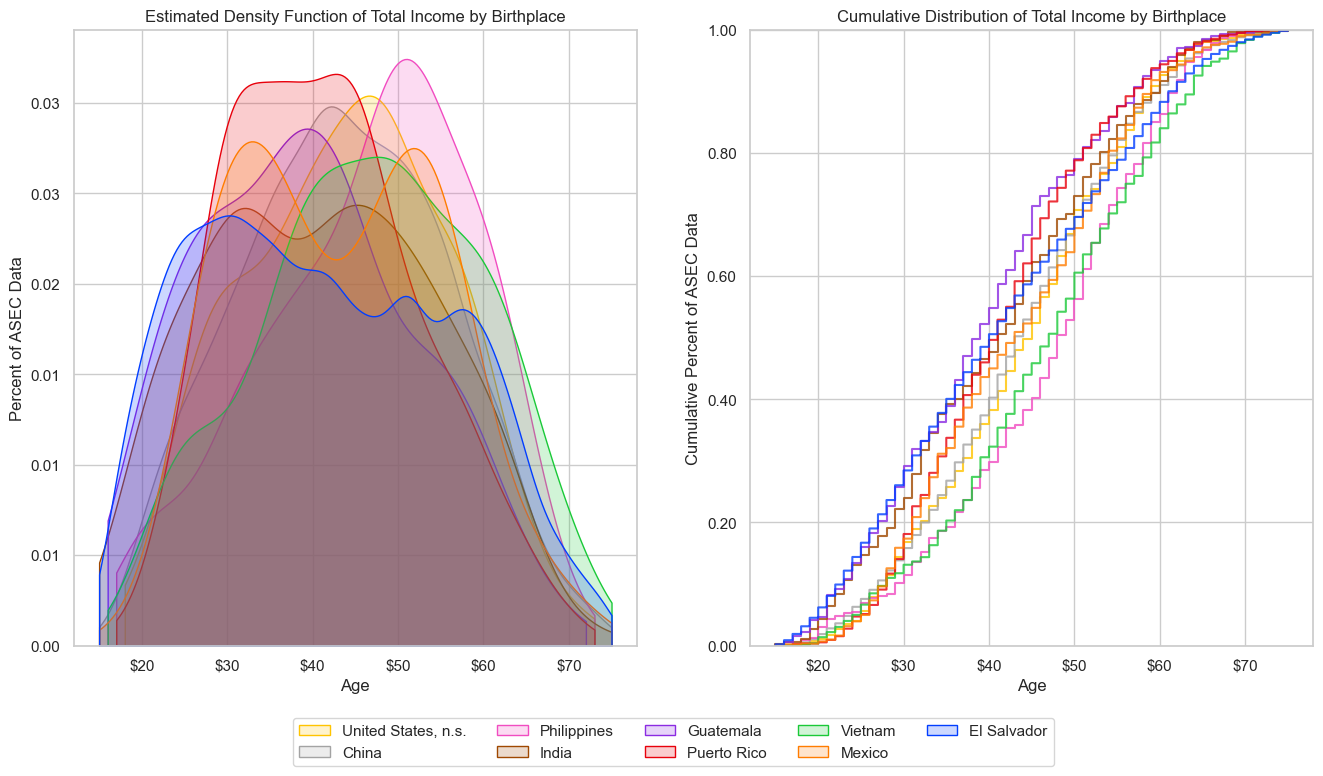

In [91]:
den_cdf_plot_by_x(df[df['LABFORCE']==2], 'Birthplace', 'Age', 'ASECWT', k=10, bbox=(0.5, -0.05), legend_ncol=5, max_percentile=0.99)

reducing records from 73863 to 67317
reducing groups from 160 to 10


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30240/331875114.py:149: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


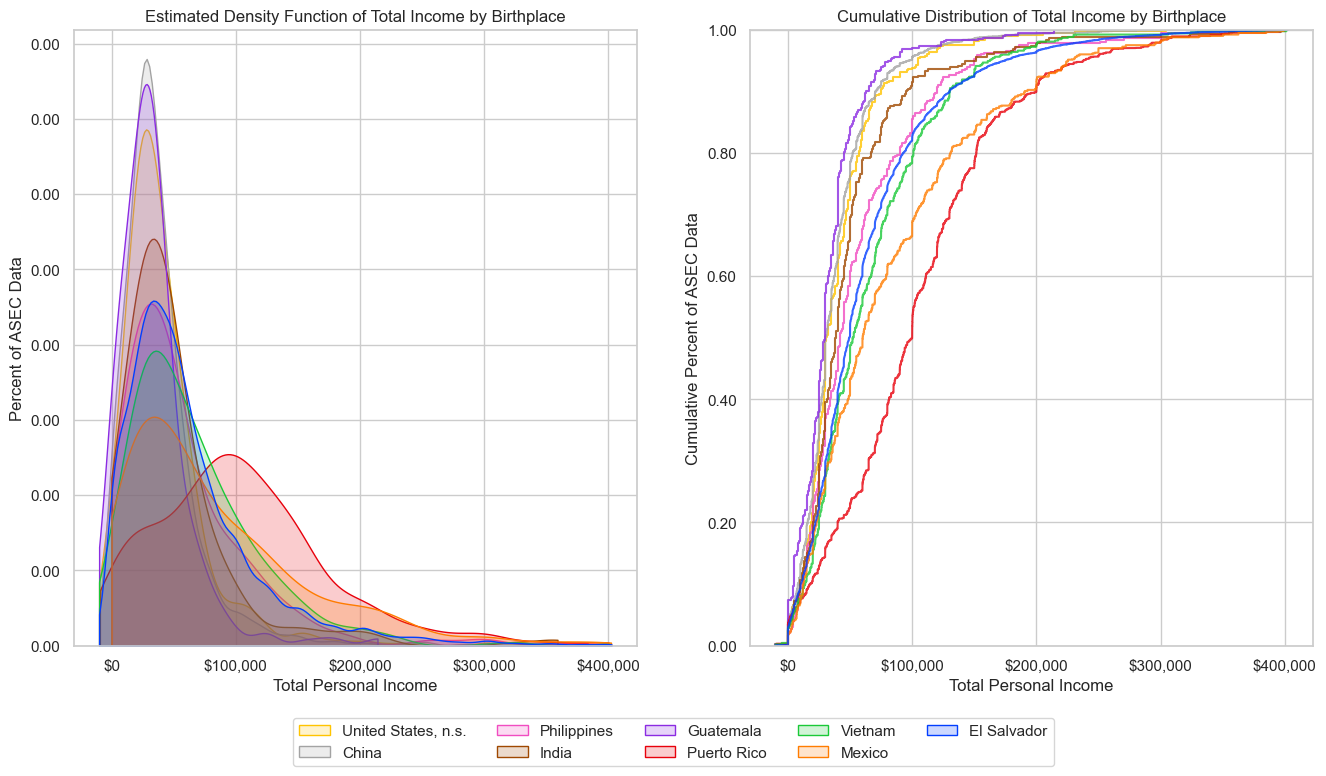

In [92]:
den_cdf_plot_by_x(df[df['LABFORCE']==2], 'Birthplace', 'INCTOT_2', 'ASECWT', k=10, bbox=(0.5, -0.05), legend_ncol=5, max_percentile=0.99)

reducing records from 73863 to 73863
reducing groups from 4 to 10


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30240/331875114.py:149: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


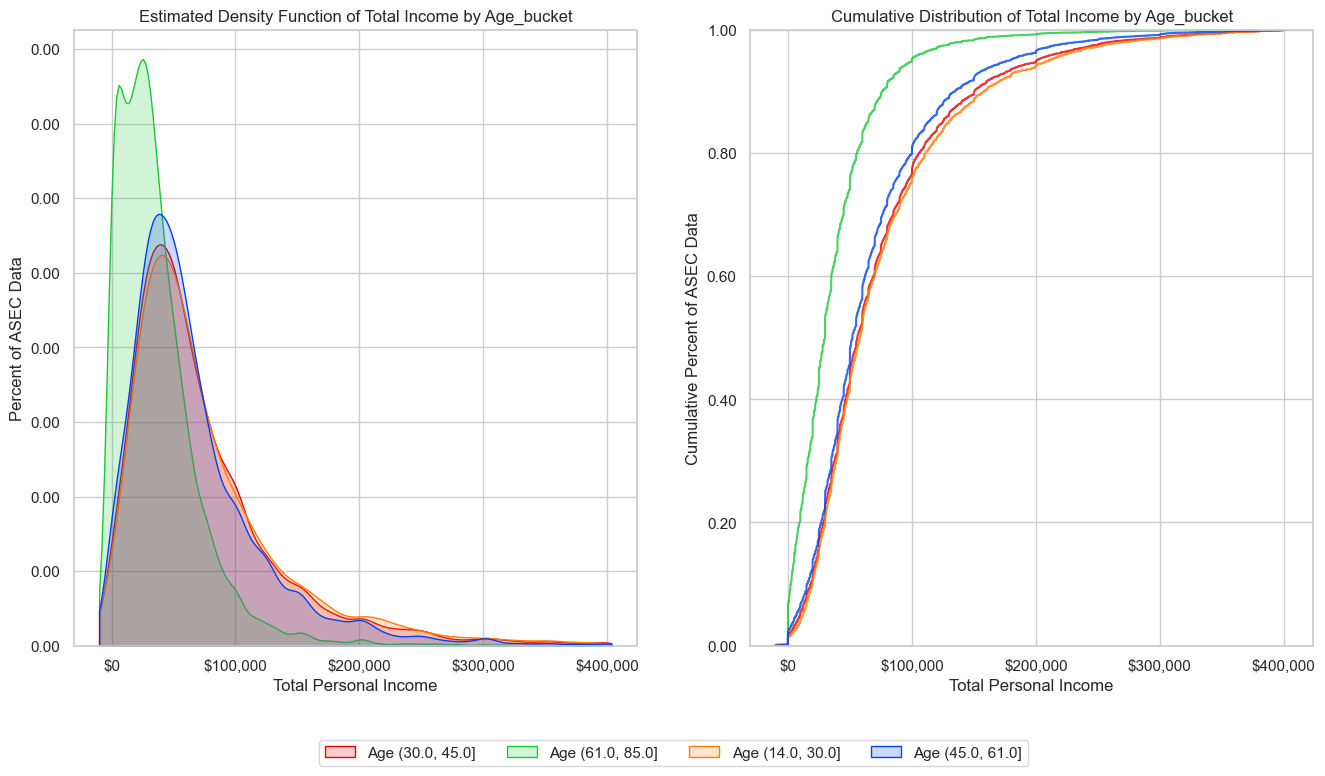

In [93]:
den_cdf_plot_by_x(df[df['LABFORCE']==2], 'Age_bucket', 'INCTOT_2', 'ASECWT', k=10, bbox=(0.5, -0.05), legend_ncol=5, max_percentile=0.99)

reducing records from 73863 to 73863
reducing groups from 5 to 10


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30240/331875114.py:149: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


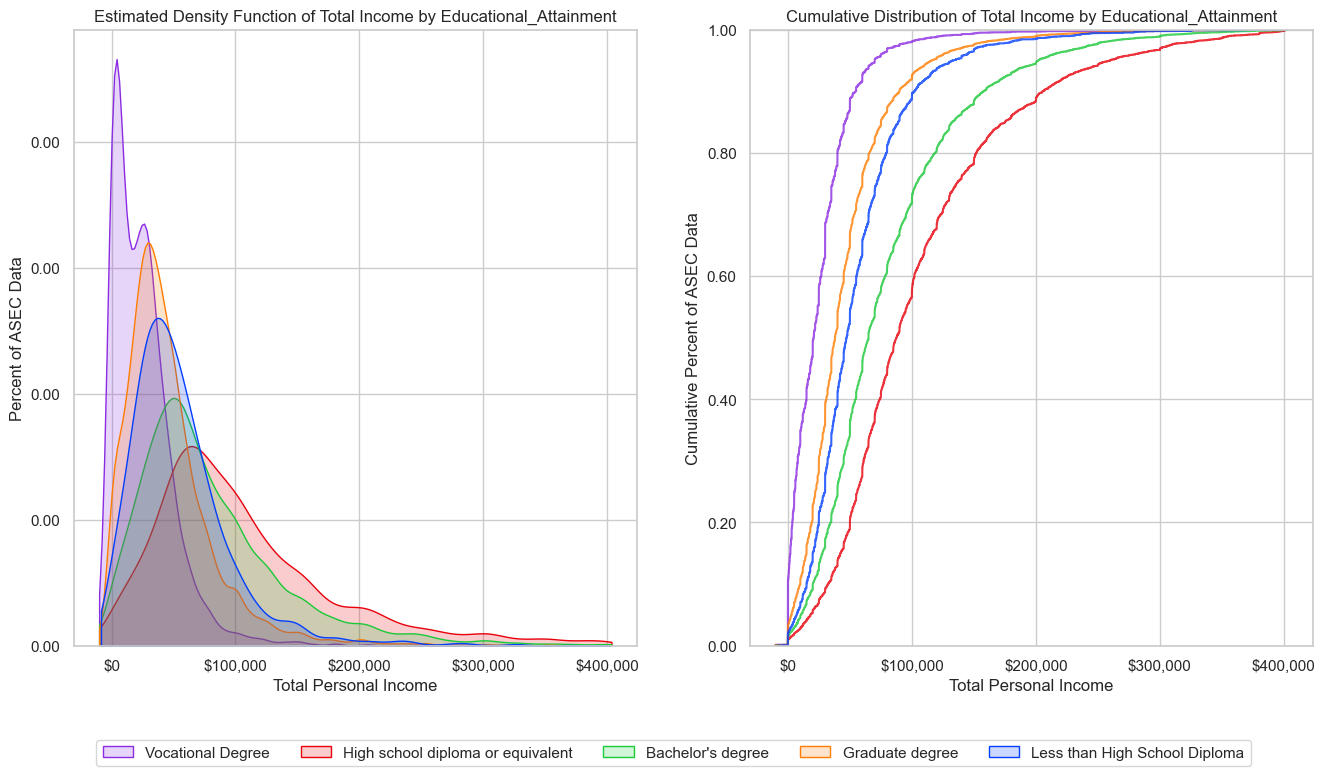

In [94]:
den_cdf_plot_by_x(df[df['LABFORCE']==2], 'Educational_Attainment', 'INCTOT_2', 'ASECWT', k=10, bbox=(0.5, -0.05), legend_ncol=5, max_percentile=0.99)

reducing records from 73863 to 71682
reducing groups from 26 to 5


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_30240/331875114.py:149: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


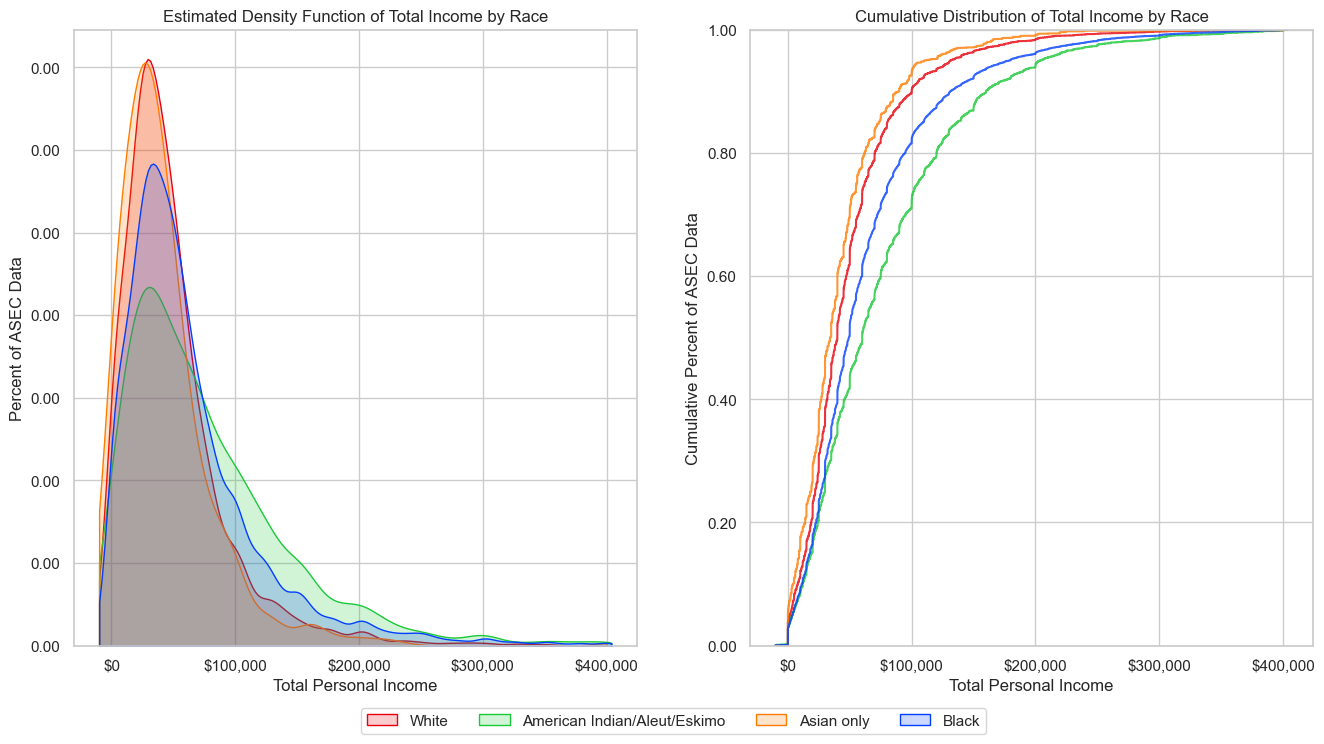

In [95]:
den_cdf_plot_by_x(df[df['LABFORCE']==2], 'Race', 'INCTOT_2', 'ASECWT', k=5, bbox=(0.5, -0.01), legend_ncol=5, max_percentile=0.99)

In [97]:
pd.options.display.max_columns = 100

In [98]:
df.head().T

0                   1                   2  \
YEAR                          2022                2022                2022   
ASECWTH                    2553.13              1586.8              1586.8   
STATEFIP                        23                  23                  23   
STAMPVAL                         0                   0                   0   
WTFINL                         NaN                 NaN                 NaN   
...                            ...                 ...                 ...   
Race_top_5                   White               White               White   
Race_full                    White               White               White   
INCTOT_3                     44220               32702               50050   
Income Buckets  (30012.0, 45000.0]  (30012.0, 45000.0]  (45000.0, 62032.0]   
Age                           42.0                62.0                64.0   

                                 3                             4  
YEAR                          2022                          2022  
ASECWTH                    1492.59                       1492.59  
STATEFIP                        23                            23  
STAMPVAL                         0                             0  
WTFINL                         NaN                           NaN  
...                            ...                           ...  
Race_top_5                   White  American Indian/Aleut/Eskimo  
Race_full                    White  American Indian/Aleut/Eskimo  
INCTOT_3                     40001                         20000  
Income Buckets  (30012.0, 45000.0]            (19868.5, 30012.0]  
Age                           26.0                          24.0  

[96 rows x 5 columns]

<Axes: >

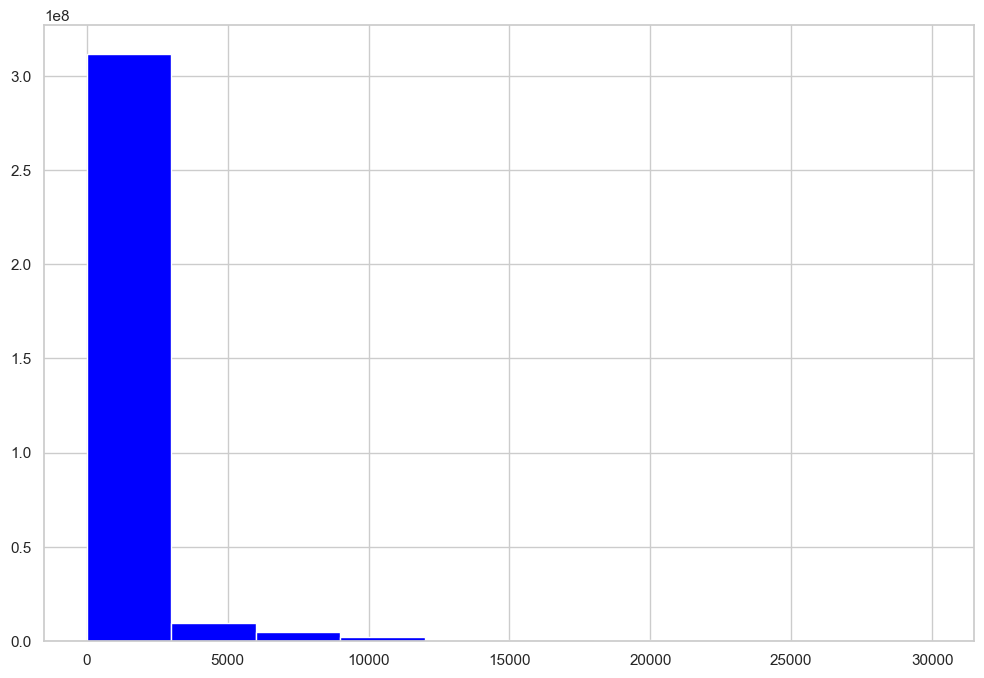

In [99]:
df['FOODSTAMP'].hist(weights=df['ASECWT'], color='blue')

In [ ]:
x = pt(ddi_codebook, df, 'EDUC')

In [ ]:
{k: 1 for k in x['EDUC'].values}

In [ ]:
pt(ddi_codebook, ipums_df, 'EMPSTAT')

In [ ]:
ipums_df['OCC'].describe().round()

In [ ]:
for col in cps_ddi['columns']:
    print(ddi_codebook.get_variable_info(col).description)
    print("*"*40)

In [ ]:
def weighted_quantiles_interpolate(values, weights, quantiles=0.5):
    i = np.argsort(values)
    c = np.cumsum(weights[i])
    q = np.searchsorted(c, quantiles * c[-1])
    return np.where(c[q]/c[-1] == quantiles, 0.5 * (values[i[q]] + values[i[q+1]]), values[i[q]])

def weighted_mode(data, weights):
    if len(data) != len(weights):
        raise ValueError("The length of data and weights must be the same.")

    values, counts = np.unique(data, return_counts=True)
    weighted_counts = np.zeros_like(counts, dtype=float)

    for i, value in enumerate(values):
        indices = np.where(data == value)
        weighted_counts[i] = np.sum(weights[indices])

    max_count = np.max(weighted_counts)
    mode = values[np.where(weighted_counts == max_count)]

    return mode.tolist()

In [ ]:
weighted_mode(df['AGE'].values, df['ASECWT'].values)

In [ ]:
df['AGE'].mode()

In [ ]:
df.shape

In [ ]:
print(ddi_codebook.get_variable_info("INCTOT").description)

In [ ]:
f, ax = plt.subplots(1)
ax = df[df['INCTOT'] < 5e6].sample(n=1000).plot(
    kind='scatter', x='AGE', y='INCTOT', 
    figsize=(12, 8), ax=ax, grid=True,
)
# max_val = dfss[dfss['INCTOT'] < 5e6]['INCTOT'].max()
# ax.set_ylim([0, max_val])

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(['${:,}'.format(int(x)) for x in ax.get_yticks().tolist()])


plt.xlabel('Age')
plt.ylabel('Income')

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

# # Put a legend below current axis
# ax.legend(['Age'], 
#           loc='upper center', bbox_to_anchor=(0.5, -0.1),
#           fancybox=True, shadow=True, ncol=2)
plt.show()

In [ ]:
np.average(df['AGE'], weights=df['ASECWT'])

In [ ]:
weighted_quantiles_interpolate(df['AGE'].values, weights=df['ASECWT'].values, quantiles=0.5)

In [ ]:
df['AGE'].hist(density=1, bins=30, weights=df['ASECWT'], color='blue', figsize=(12, 8))
plt.xlabel('Reported Age in Years')
plt.show()

In [ ]:
f, ax = plt.subplots(1)
ax = df['AGE'].plot(kind='density', grid=True, figsize=(12, 8))
ax.set_xlim([0, 100])
# ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
# plt.title()
plt.xlabel("Age")
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
# Put a legend below current axis
ax.legend(['Age'], 
          loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=2)

plt.show()

In [ ]:
dfss[filt1|filt2]['INCWAGE'].describe()

In [ ]:
xvar = 'EMPSTAT'
print(ddi_codebook.get_variable_info(xvar).description)
print(ddi_codebook.get_variable_info(xvar).codes)

In [ ]:
dfss['EMPSTAT'].describe()

In [ ]:
filt1 = (dfss['YEAR']==2021) & (dfss['EDUCD'] <= 113) & ((dfss['EMPSTAT']==1) | (dfss['EMPSTAT']==0))
filt2 = (dfss['YEAR']==2021) & (dfss['EDUCD'] > 113) & ((dfss['EMPSTAT']==1) | (dfss['EMPSTAT']==0))

f, ax = plt.subplots(1)
ax = dfss[filt1]['INCWAGE'].plot(kind='density', grid=True, figsize=(12, 8))
ax = dfss[filt2]['INCWAGE'].plot(kind='density', grid=True, title="Wage Income by Educational Attainment for People in the Labor Force (ACS 2021)")
ax.set_xlim([0, 1e6])
# ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
ax.set_xticklabels(['${:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
# plt.title()
plt.xlabel("Wage Income")
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(['Less than a Graduate Degree', 'Graduate Degree or more'], 
          loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=2)

plt.show()

In [ ]:
def gen_plot(df, xvar, codebook):
    xtitle = codebook.get_variable_info(xvar).label.title()
    filt1 = (df['YEAR']==2021) & (df['EDUCD'] <= 113) & ((df['EMPSTAT']==1) | (df['EMPSTAT']==0))
    filt2 = (df['YEAR']==2021) & (df['EDUCD'] > 113) & ((df['EMPSTAT']==1) | (df['EMPSTAT']==0))

    f, ax = plt.subplots(1)
    ax = df[filt1][xvar].plot(kind='hist', grid=True, figsize=(12, 8), weights=df[filt1]['PERWT'])
    ax = df[filt2][xvar].plot(kind='hist', grid=True, weights=df[filt2]['PERWT'], title=f"{xtitle} by Educational Attainment for People in the Labor Force (ACS 2021)")
    max_val = df[xvar].max()
    ax.set_xlim([0, max_val])
    ax.set_xticklabels(['${:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
    plt.xlabel(xtitle)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])

    # Put a legend below current axis
    ax.legend(['Less than a Graduate Degree', 'Graduate Degree or more'], 
              loc='upper center', bbox_to_anchor=(0.5, -0.1),
              fancybox=True, shadow=True, ncol=2)
    plt.show()

In [ ]:
print([j for j in cps_ddi['columns'] if 'INC' in j])

In [ ]:
for j in cps_ddi['columns']:
    if 'INC' in j:
        gen_plot(dfss, j, ddi_codebook)
        print("*"*40)

In [ ]:
gen_plot(dfss, 'INCWAGE', ddi_codebook)